# Libraries

In [1]:
import requests
import pandas as pd
import json
from typing import Optional, Dict, Any, List
from missingno import matrix
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import seaborn as sns
from fastai.tabular.core import add_datepart
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, AffinityPropagation, SpectralClustering
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
import gower
import warnings
warnings.filterwarnings('ignore')

## No column display limit

In [2]:
pd.set_option('display.max_columns', None)

# Data extraction

## API setup

In [3]:
class LongBeachAnimalShelterAPI:
    """
    A Python client for extracting data from the Long Beach Animal Shelter API
    using the Opendatasoft Explore API v2.1
    """
    
    def __init__(self):
        self.base_url = "https://longbeach.opendatasoft.com/api/explore/v2.1"
        self.dataset_id = "animal-shelter-intakes-and-outcomes"
        
    def get_all_records(self, 
                       select: Optional[str] = None,
                       where: Optional[str] = None,
                       order_by: Optional[str] = None) -> pd.DataFrame:
        """
        Extract all records from the animal shelter dataset without limits.
        
        Args:
            select: Fields to select (default: all fields)
            where: Filter conditions using ODSQL syntax
            order_by: Order by clause
            
        Returns:
            pandas.DataFrame with all records
        """
        
        all_records = []
        offset = 0
        limit = 100  # Maximum allowed per request
        
        while True:
            # Build API request
            url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/records"
            
            params = {
                'limit': limit,
                'offset': offset
            }
            
            # Add optional parameters
            if select:
                params['select'] = select
            if where:
                params['where'] = where
            if order_by:
                params['order_by'] = order_by
                
            try:
                response = requests.get(url, params=params)
                response.raise_for_status()
                
                data = response.json()
                
                # Extract records from response
                records = data.get('results', [])
                
                if not records:
                    break
                    
                all_records.extend(records)
                
                # Check if we've retrieved all records
                total_count = data.get('total_count', 0)
                if len(all_records) >= total_count:
                    break
                    
                # Move to next batch
                offset += limit
                
                print(f"Retrieved {len(all_records)} of {total_count} records...")
                
            except requests.RequestException as e:
                print(f"Error fetching data: {e}")
                break
                
        # Convert to DataFrame
        df = pd.DataFrame(all_records)
        print(f"Successfully retrieved {len(df)} total records")
        
        return df
    
    def get_dataset_info(self) -> Dict[str, Any]:
        """
        Get metadata about the dataset including field information.
        
        Returns:
            Dictionary with dataset metadata
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
            
        except requests.RequestException as e:
            print(f"Error fetching dataset info: {e}")
            return {}
    
    def export_to_csv(self, 
                     filename: str = "animal_shelter_data.csv",
                     select: Optional[str] = None,
                     where: Optional[str] = None) -> bool:
        """
        Export data directly to CSV using the API's export endpoint.
        
        Args:
            filename: Output CSV filename
            select: Fields to select
            where: Filter conditions
            
        Returns:
            True if successful, False otherwise
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/exports/csv"
        
        params = {'limit': -1}  # -1 means no limit for exports
        
        if select:
            params['select'] = select
        if where:
            params['where'] = where
            
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Data exported to {filename}")
            return True
            
        except requests.RequestException as e:
            print(f"Error exporting data: {e}")
            return False

## Run

In [4]:
if __name__ == "__main__":
    
    # Initialize the API client
    api = LongBeachAnimalShelterAPI()
    
    # Example 1: Get all records
    print("Fetching all animal shelter records...")
    df = api.get_all_records()
    print(f"Retrieved {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    
    
    # Example 5: Export directly to CSV
    print("\nExporting all data to CSV...")
    api.export_to_csv("longbeach_animal_shelter_complete.csv")
    
    
    # Display sample data
    if not df.empty:
        print("\nSample data:")
        print(df.head())

Fetching all animal shelter records...
Retrieved 100 of 32664 records...
Retrieved 200 of 32664 records...
Retrieved 300 of 32664 records...
Retrieved 400 of 32664 records...
Retrieved 500 of 32664 records...
Retrieved 600 of 32664 records...
Retrieved 700 of 32664 records...
Retrieved 800 of 32664 records...
Retrieved 900 of 32664 records...
Retrieved 1000 of 32664 records...
Retrieved 1100 of 32664 records...
Retrieved 1200 of 32664 records...
Retrieved 1300 of 32664 records...
Retrieved 1400 of 32664 records...
Retrieved 1500 of 32664 records...
Retrieved 1600 of 32664 records...
Retrieved 1700 of 32664 records...
Retrieved 1800 of 32664 records...
Retrieved 1900 of 32664 records...
Retrieved 2000 of 32664 records...
Retrieved 2100 of 32664 records...
Retrieved 2200 of 32664 records...
Retrieved 2300 of 32664 records...
Retrieved 2400 of 32664 records...
Retrieved 2500 of 32664 records...
Retrieved 2600 of 32664 records...
Retrieved 2700 of 32664 records...
Retrieved 2800 of 32664 r

In [5]:
df = pd.read_csv("longbeach_animal_shelter_complete.csv", sep=None, engine='python')

## Data info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32664 entries, 0 to 32663
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ﻿animal_id         32664 non-null  object 
 1   animal_name        19191 non-null  object 
 2   animal_type        32664 non-null  object 
 3   primary_color      32664 non-null  object 
 4   secondary_color    15659 non-null  object 
 5   sex                32664 non-null  object 
 6   dob                28561 non-null  object 
 7   intake_date        32664 non-null  object 
 8   intake_cond        32664 non-null  object 
 9   intake_type        32664 non-null  object 
 10  intake_subtype     32218 non-null  object 
 11  reason             2197 non-null   object 
 12  outcome_date       32428 non-null  object 
 13  crossing           32664 non-null  object 
 14  jurisdiction       32663 non-null  object 
 15  outcome_type       32417 non-null  object 
 16  outcome_subtype    289

## Data preview

In [7]:
df.head()

,﻿animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,intake_duration,is_current_month
0,A708149,NaN,REPTILE,BROWN,GREEN,Unknown,NaN,2023-10-03,NORMAL,STRAY,FIELD,NaN,2023-10-03,"`600 BLK E HARCOURT, LB 90805",LONG BEACH,RESCUE,OTHER RESC,33.867999,-118.200931,Alive on Intake,False,1,"33.8679994, -118.2009307",0.0,0
1,A705745,*OAKLEY,DOG,GRAY,TRICOLOR,Neutered,2021-08-30,2023-08-30,NORMAL,STRAY,OTC,NaN,2023-09-03,+2400 BLK E 15TH LONG BEACH CA 90804,LONG BEACH,ADOPTION,NaN,33.786225,-118.163308,Alive on Intake,False,1,"33.7862248, -118.1633079",4.0,0
2,A683199,NaN,REPTILE,BROWN,NaN,Unknown,NaN,2022-09-06,NORMAL,STRAY,FIELD,NaN,2022-09-19,"0 BLK ORIZABA AVE, LONG BEACH, CA 90803",LONG BEACH,RESCUE,SC REPTILE,33.762118,-118.157944,Alive on Intake,False,1,"33.7621185, -118.1579439",13.0,0
3,A639310,NaN,BIRD,WHITE,GRAY,Unknown,NaN,2020-02-02,ILL SEVERE,WILDLIFE,FIELD,NaN,2020-02-02,"0 BLK TEMPLE AVE, LONG BEACH, CA 90803",LONG BEACH,TRANSFER,LBAH,33.762460,-118.159678,Alive on Intake,False,1,"33.7624598, -118.1596777",0.0,0
4,A740317,NaN,OTHER,BLACK,GRAY,Unknown,2025-04-20,2025-05-04,UNDER AGE/WEIGHT,WILDLIFE,FIELD,NaN,2025-05-04,"0 BLK W DAMERON ST, LONG BEACH, CA, 90805",LONG BEACH,TRANSPORT,OTHER RESC,33.866660,-118.201795,Alive on Intake,False,1,"33.8666597, -118.2017946",0.0,0


## Data format change for pandas

In [8]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '') # Removing whitespaces in column names

## Duplicates

In [9]:
# Check for duplicates by animal_id
df[df.duplicated('animal_id', keep=False)]

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,intake_duration,is_current_month
5,A710397,*CAMMIE,DOG,BLACK,BROWN,Female,2022-11-12,2023-11-12,NORMAL,WELFARE SEIZED,POLICE,NaN,2023-12-15,"00 39TH PL, LONG BEACH CA",LONG BEACH,ADOPTION,NaN,33.760205,-118.147768,Alive on Intake,False,1,"33.760205, -118.1477682",33.0,0
9,A604840,GOLIATH,DOG,TAN,WHITE,Neutered,2015-03-15,2019-08-04,NORMAL,STRAY,FIELD,NaN,2019-08-11,"00 BLK E 68TH ST, LONG BEACH, CA 90805",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.877607,-118.203483,Alive on Intake,False,1,"33.8776071, -118.2034825",7.0,0
10,A589439,*EGG YOLK,CAT,ORANGE,WHITE,Neutered,2015-04-29,2017-07-12,FERAL,STRAY,FIELD,NaN,2017-07-13,"00 BLK E MARKET ST, LONG BEACH, CA 90805",LONG BEACH,RETURN TO RESCUE,STRAYCATAL,33.854284,-118.196492,Alive on Intake,False,1,"33.8542837, -118.1964921",1.0,0
17,A725104,*LATTE,DOG,WHITE,CREAM,Spayed,2023-07-19,2025-01-10,NORMAL,RETURN,NaN,OWNER PROB,2025-03-01,"00 BLOCK CREEKSIDE DR, SAN MARCOS CA 92078",OUT OF AREA,ADOPTION,WEB,33.134394,-117.181034,Alive on Intake,False,1,"33.1343945, -117.181034",50.0,0
33,A723857,JAMES BOND,DOG,BLACK,NaN,Male,2012-07-03,2024-07-17,ILL SEVERE,OWNER SURRENDER,OTC,ILL,2024-07-17,00 S ATLANTIC AVE LONG BEACH CA 90802,LONG BEACH,EUTHANASIA,ILL SEVERE,33.766432,-118.185045,Alive on Intake,True,0,"33.7664319, -118.1850452",0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32628,A639236,BOOMER,DOG,BROWN,NaN,Neutered,2012-01-30,2020-09-24,NORMAL,WELFARE SEIZED,HOSPITAL,NaN,2020-11-01,"400 BLK W 3RD ST, LONG BEACH, CA 90802",LONG BEACH,ADOPTION,WEB,33.770510,-118.196381,Alive on Intake,False,1,"33.7705095, -118.1963808",38.0,0
32635,A630106,SNOWFLAKE,DOG,BLACK,WHITE,Spayed,2018-07-18,2019-07-18,NORMAL,STRAY,OTC,NaN,2019-07-19,"400 BLK W 8TH ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,WEB,33.776552,-118.196363,Alive on Intake,False,1,"33.7765518, -118.1963626",1.0,0
32651,A576092,TUT,DOG,GRAY,WHITE,Male,2016-01-28,2019-10-24,NORMAL,OWNER SURRENDER,OTC,NaN,2019-11-21,"400 BLK WALNUT AVE, LONG BEACH, CA 90802",LONG BEACH,EUTHANASIA,BEH SEVERE,33.771719,-118.172009,Alive on Intake,True,0,"33.771719, -118.1720092",28.0,0
32652,A657527,MERLIN,CAT,BLACK,NaN,Neutered,2013-05-17,2023-01-12,FRACTIOUS,STRAY,OTC,OWNER DIED,2023-03-16,"400 BLK. E LOUISE ST, LONG BEACH, CA 90805",LONG BEACH,RESCUE,CATHSEKING,33.855133,-118.188381,Alive on Intake,False,1,"33.8551325, -118.1883812",63.0,0


In [10]:
# Find all animal_ids that are duplicated
duplicate_ids = df['animal_id'][df['animal_id'].duplicated(keep=False)]

# Show all rows with these duplicate animal_ids, sorted/grouped by animal_id
duplicates_grouped = df[df['animal_id'].isin(duplicate_ids)].sort_values('animal_id')

### Duplicates df

In [11]:
duplicates_grouped.head()

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,intake_duration,is_current_month
3176,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-15,ILL MILD,OWNER SURRENDER,OTC,UNKNOWN,2017-03-22,"1800 LEWIS AVE, LONG BEACH, CA 90804",LONG BEACH,RESCUE,KITTYKATCH,33.789867,-118.179607,Alive on Intake,False,1,"33.7898666, -118.1796068",7.0,0
18489,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-05,INJURED MILD,STRAY,FIELD,NaN,2017-03-10,"500 E 15TH ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,WALKIN,33.785633,-118.186493,Alive on Intake,False,1,"33.7856334, -118.1864934",5.0,0
14261,A279626,LANE,DOG,BROWN,NaN,Neutered,2006-06-07,2018-03-12,NORMAL,STRAY,OTC,NaN,2018-03-17,"1100 RAYMOND AVE, LONG BEACH, CA 90804",LONG BEACH,RETURN TO OWNER,WALKIN,33.780745,-118.164395,Alive on Intake,False,1,"33.7807454, -118.1643953",5.0,0
24007,A279626,LANE,DOG,BROWN,NaN,Neutered,2006-06-07,2018-06-09,NORMAL,STRAY,FIELD,NaN,2018-06-13,"65TH ST / CHERRY AVE, LONG BEACH, CA 90805",LONG BEACH,RETURN TO OWNER,WALKIN,33.872461,-118.168587,Alive on Intake,False,1,"33.8724609, -118.1685866",4.0,0
3044,A279626,LANE,DOG,BROWN,NaN,Neutered,2006-06-07,2017-10-21,NORMAL,STRAY,FIELD,NaN,2017-10-26,"1800 BLK OBISPO AVE, SIGNAL HILL, CA 90755",SIGNAL HILL,RETURN TO OWNER,FRE RID HM,33.789848,-118.154575,Alive on Intake,False,1,"33.7898479, -118.1545754",5.0,0


### Count of duplicates by intake type

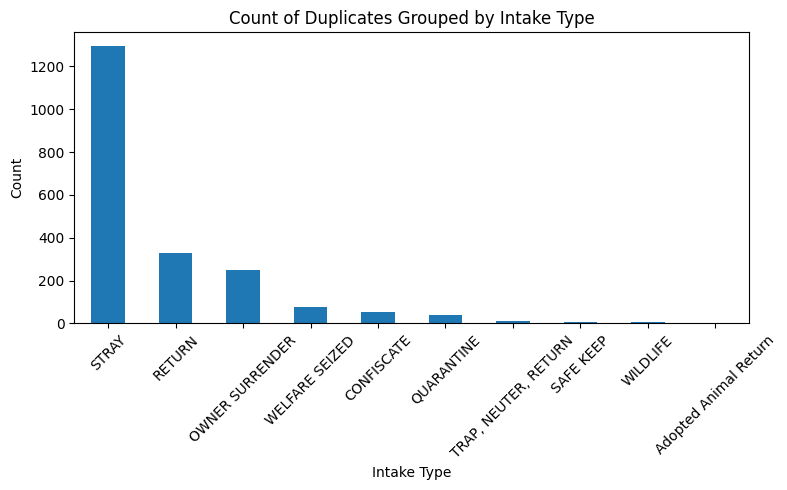

In [12]:
# 1. Histogram: count of duplicates grouped by intake_type
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_type'].value_counts().plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Count of duplicates by outcome type

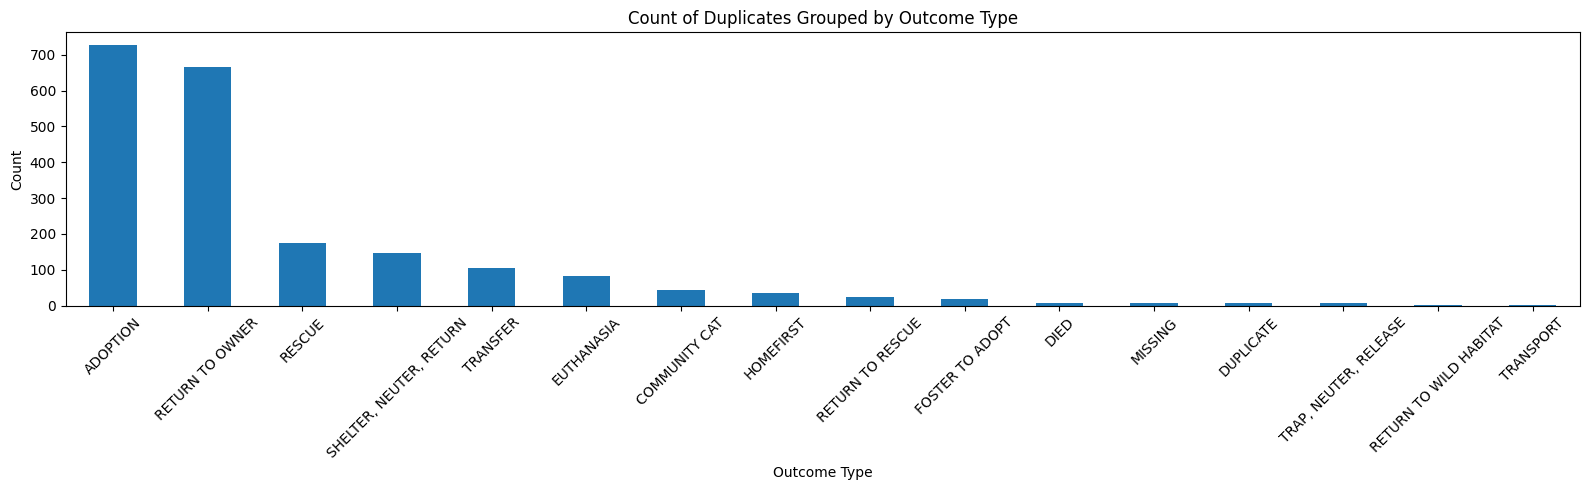

In [13]:
# 2. Histogram: count of duplicates grouped by outcome_type
plt.figure(figsize=(16, 5))
duplicates_grouped['outcome_type'].value_counts().plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Count of duplicates by intake condition

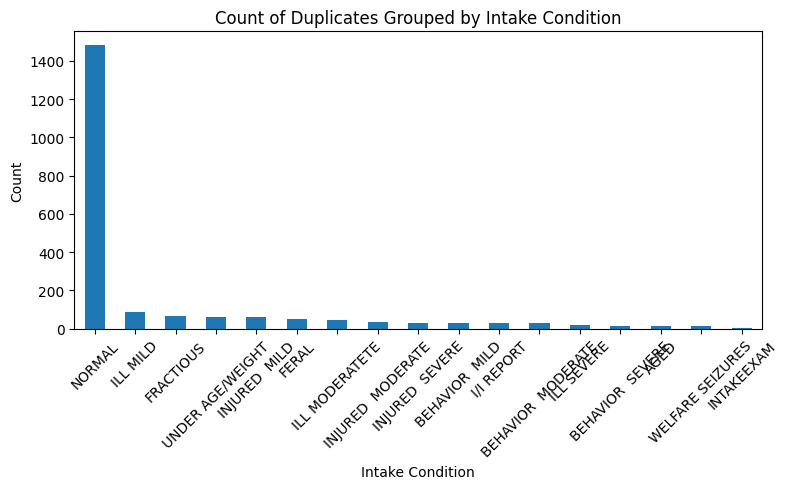

In [14]:
# 3. Histogram: count of duplicates grouped by intake_cond
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_cond'].value_counts().plot(kind='bar')
plt.xlabel('Intake Condition')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Find all animal_ids that are duplicated
duplicate_counts = df['animal_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]

# Create a DataFrame with animal_id and number of duplicates
duplicates_summary = duplicate_counts.reset_index()
duplicates_summary.columns = ['animal_id', 'number_of_duplicates']

In [16]:
duplicates_summary.describe()

,number_of_duplicates
count,940.000000
mean,2.196809
std,0.575124
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,8.000000


Insights about returned animals:
1. Most returned animals are returned twice
2. 944 animals were returned
3. Most returned animals were normal upon intake
4. 132 animals have returned more than twice

In [17]:
duplicates_summary[duplicates_summary['number_of_duplicates'] > 2]

,animal_id,number_of_duplicates
0,A637086,8
1,A637269,7
2,A279626,6
3,A581276,5
4,A542375,5
...,...,...
128,A615192,3
129,A597205,3
130,A638651,3
131,A735502,3


# Data cleaning & Processing 1

## Datetime conversion

In [18]:
# Convert *dob*, *intake_date*, *outcome_date* to datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['intake_date'] = pd.to_datetime(df['intake_date'], errors='coerce')
df['outcome_date'] = pd.to_datetime(df['outcome_date'], errors='coerce')

## Adding time to outcome

In [19]:
df['time_to_outcome'] = df['outcome_date'] - df['intake_date'] # Calculate time to outcome in days

## Dealing with duplicates

In [20]:
df = df.sort_values(['animal_id', 'intake_date'])

In [21]:
# Create visit_count using groupby and cumcount
df['visit_count'] = df.groupby('animal_id').cumcount() + 1

In [22]:
# Additional useful features
df['is_return_visit'] = (df['visit_count'] > 1).astype(int)
df['is_frequent_returner'] = (df['visit_count'] > 2).astype(int)

In [23]:
# Advanced features for return animals
df['days_since_last_visit'] = df.groupby('animal_id')['intake_date'].diff().dt.days
df['days_since_last_visit'] = df['days_since_last_visit'].fillna(-1)
df['previous_outcome_type'] = df.groupby('animal_id')['outcome_type'].shift(1)
df['previous_outcome_type'] = df['previous_outcome_type'].fillna('First Visit')

# EDA pt. 1

## Return stats

In [24]:
print(f"Visit count distribution:")
print(df['visit_count'].value_counts().sort_index())
print(f"\nReturn visit rate: {df['is_return_visit'].mean():.1%}")
print(f"\nFrequent returner rate: {df['is_frequent_returner'].mean():.1%}")
print(f"\nMean days between visits: {df['days_since_last_visit'].mean():.1f}")
print(f"\nMedian days between visits: {df['days_since_last_visit'].median():.1f}")
print(f"\nMost common previous outcome for returns:")
print(df[df['is_return_visit']==1]['previous_outcome_type'].value_counts().head())

Visit count distribution:
visit_count
1    31539
2      940
3      133
4       33
5       13
6        3
7        2
8        1
Name: count, dtype: int64

Return visit rate: 3.4%

Frequent returner rate: 0.6%

Mean days between visits: 7.1

Median days between visits: -1.0

Most common previous outcome for returns:
previous_outcome_type
RETURN TO OWNER            434
ADOPTION                   412
SHELTER, NEUTER, RETURN    114
TRANSFER                    39
HOMEFIRST                   31
Name: count, dtype: int64


## Null value analysis

In [25]:
# Percentage of null values in each column
df.isnull().mean()*100

animal_id                 0.000000
animal_name              41.247245
animal_type               0.000000
primary_color             0.000000
secondary_color          52.060372
sex                       0.000000
dob                      12.561229
intake_date               0.000000
intake_cond               0.000000
intake_type               0.000000
intake_subtype            1.365418
reason                   93.273941
outcome_date              0.722508
crossing                  0.000000
jurisdiction              0.003061
outcome_type              0.756184
outcome_subtype          11.330517
latitude                  0.000000
longitude                 0.000000
intake_is_dead            0.000000
outcome_is_dead           0.000000
was_outcome_alive         0.000000
geopoint                  0.000000
intake_duration           0.722508
is_current_month          0.000000
time_to_outcome           0.722508
visit_count               0.000000
is_return_visit           0.000000
is_frequent_returner

## MSNO matrix

<Axes: >

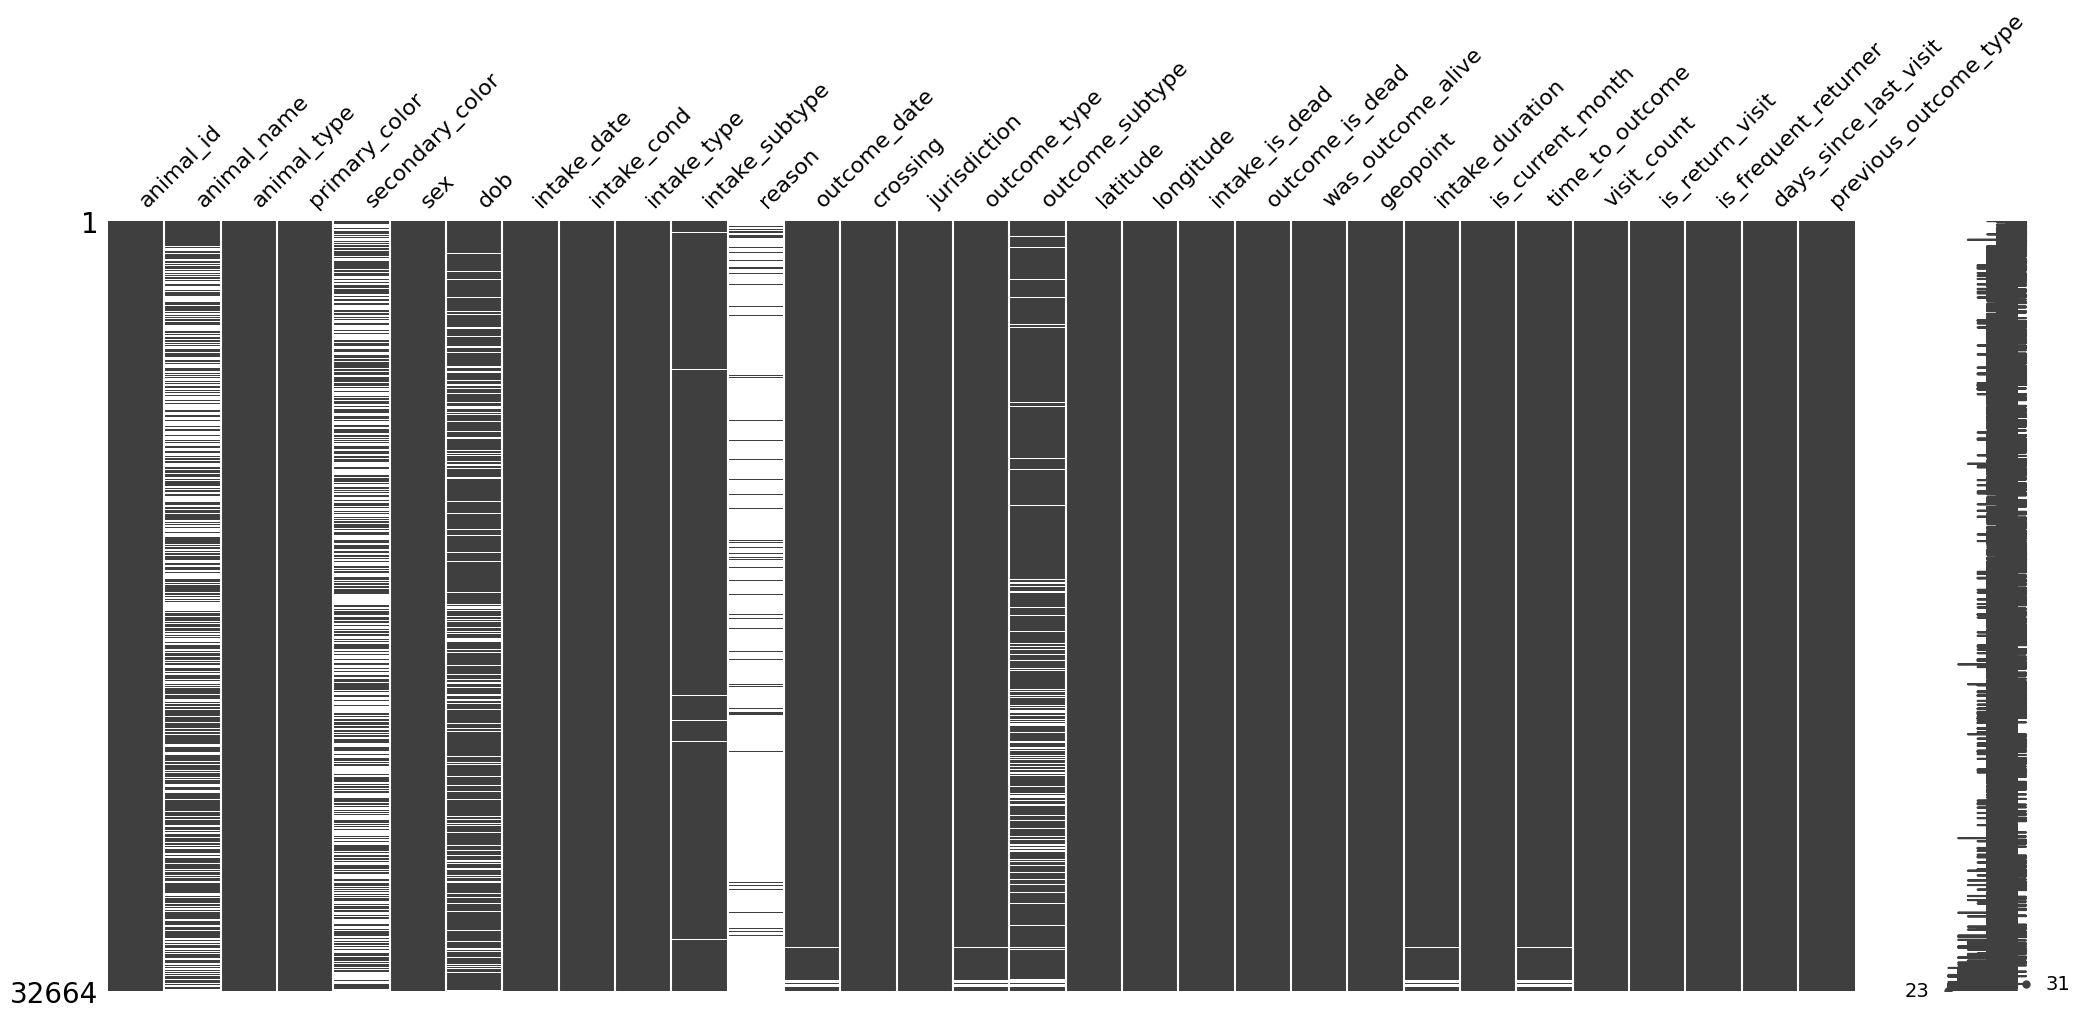

In [26]:
matrix(df)

## Outcome type count

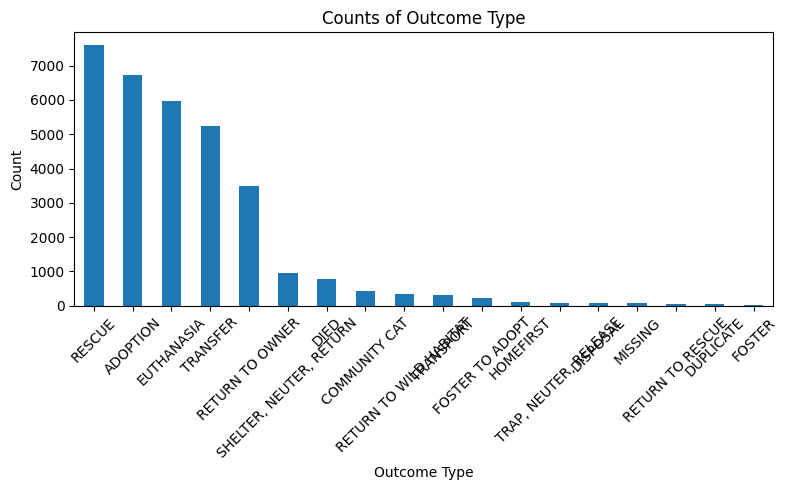

In [27]:
# Get value counts for outcome_type
counts = df['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Animal type counts

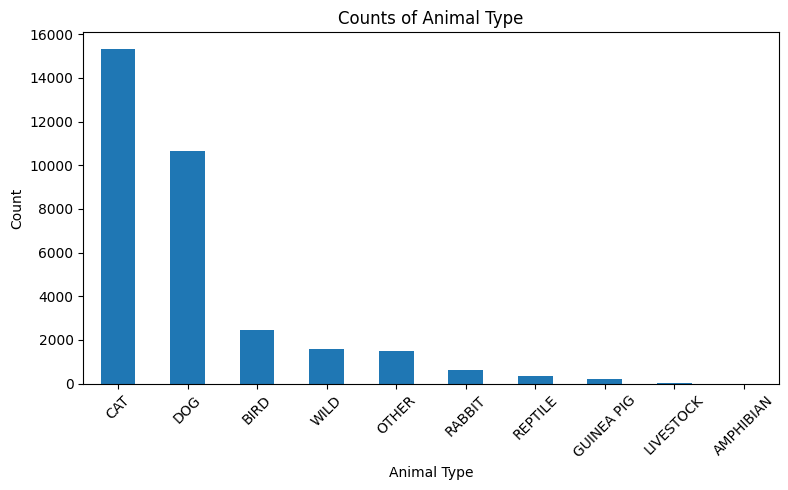

In [28]:
# Get value counts for animal_type
counts = df['animal_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Counts of Animal Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Intake type count

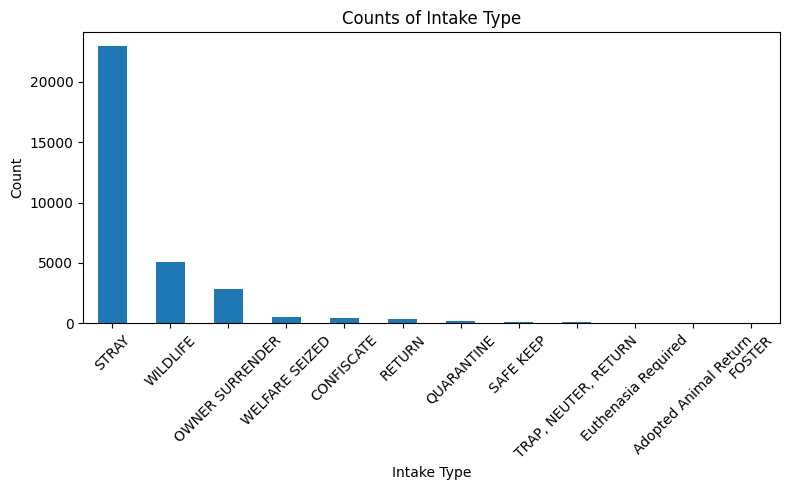

In [29]:
# Get value counts for intake_type
counts = df['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DOB null grouped by intake type

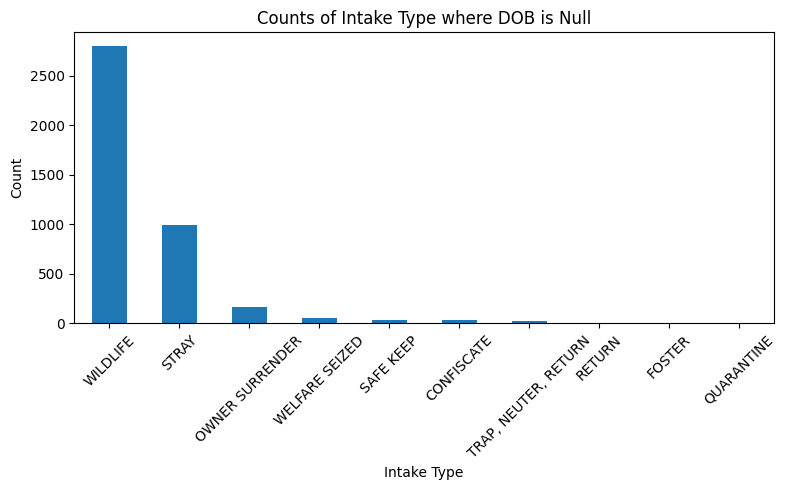

In [30]:
# Filter rows where dob is null
null_dob = df[df['dob'].isnull()]

# Get value counts for intake_type in these rows
counts = null_dob['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type where DOB is Null')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
counts.head(10)

intake_type
WILDLIFE                2799
STRAY                    991
OWNER SURRENDER          164
WELFARE SEIZED            51
SAFE KEEP                 33
CONFISCATE                32
TRAP, NEUTER, RETURN      28
RETURN                     3
FOSTER                     1
QUARANTINE                 1
Name: count, dtype: int64

# Data cleaning & Processing 2

## Statistical/Domain-knowledge based imputation for DOB

In [32]:
def impute_dob_statistical(df):
    """Impute DOB using statistical measures from similar animals"""
    df_imputed = df.copy()
    
    # Calculate age for animals with known DOB
    known_mask = df_imputed['dob'].notna()
    df_imputed.loc[known_mask, 'age_at_intake_days'] = (
        df_imputed.loc[known_mask, 'intake_date'] - df_imputed.loc[known_mask, 'dob']
    ).dt.days
    
    # Group by animal_type and intake_type for imputation
    imputation_groups = ['animal_type', 'intake_type', 'sex']
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        # Get characteristics of current animal
        animal_info = df_imputed.loc[idx]
        
        # Find similar animals with known DOB
        similar_animals = df_imputed[
            (df_imputed['animal_type'] == animal_info['animal_type']) &
            (df_imputed['intake_type'] == animal_info['intake_type']) &
            (df_imputed['sex'] == animal_info['sex']) &
            (df_imputed['dob'].notna())
        ]
        
        # If no exact match, broaden the criteria
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['intake_type'] == animal_info['intake_type']) &
                (df_imputed['dob'].notna())
            ]
        
        # If still no match, use animal_type only
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['dob'].notna())
            ]
        
        if len(similar_animals) > 0:
            # Use median age of similar animals
            median_age_days = similar_animals['age_at_intake_days'].median()
            
            # FIX: Check if median is valid and convert to int
            if pd.notna(median_age_days):
                # Calculate imputed DOB
                imputed_dob = animal_info['intake_date'] - timedelta(days=int(median_age_days))
                df_imputed.loc[idx, 'dob'] = imputed_dob
                imputed_count += 1
    
    print(f"Strategy 1: Imputed DOB for {imputed_count} animals using statistical method")
    return df_imputed

def impute_dob_domain_knowledge(df):
    """Impute DOB using domain knowledge about animal shelters"""
    df_imputed = df.copy()
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        animal_info = df_imputed.loc[idx]
        intake_date = animal_info['intake_date']
        
        # Define typical ages based on intake type and condition
        if animal_info['intake_type'] == 'WILDLIFE':
            # Wildlife often comes in as injured adults or orphaned babies
            if 'WEIGHT' in str(animal_info['intake_cond']).upper():
                # Likely a baby if underweight
                estimated_age_days = np.random.normal(30, 15)  # 1 month ± 2 weeks
            else:
                # Likely adult wildlife
                estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
                
        elif animal_info['intake_type'] == 'STRAY':
            # Strays are often young adults who got lost
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(548, 365)  # 1.5 years ± 1 year
            else:  # DOG
                estimated_age_days = np.random.normal(730, 365)  # 2 years ± 1 year
                
        elif animal_info['intake_type'] == 'OWNER SURRENDER':
            # Owner surrenders often older animals due to life changes
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(1095, 730)  # 3 years ± 2 years
            else:  # DOG
                estimated_age_days = np.random.normal(1460, 1095)  # 4 years ± 3 years
                
        else:
            # Default for other types
            estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
        
        # Ensure positive age and not born in the future
        estimated_age_days = max(1, estimated_age_days)
        estimated_age_days = min(estimated_age_days, 5475)  # Max 15 years
        
        # FIX: Convert to int for timedelta
        # Calculate DOB
        imputed_dob = intake_date - timedelta(days=int(estimated_age_days))
        df_imputed.loc[idx, 'dob'] = imputed_dob
        imputed_count += 1
    
    print(f"Strategy 2: Imputed DOB for {imputed_count} animals using domain knowledge")
    return df_imputed

def impute_dob_hybrid(df):
    """Combine multiple strategies for best results"""
    df_imputed = df.copy()
    
    print("Hybrid DOB Imputation Strategy:")
    print("=" * 40)
    
    # First, try statistical imputation for animals with many similar examples
    df_imputed = impute_dob_statistical(df_imputed)
    
    # Then, use domain knowledge for remaining missing values
    remaining_missing = df_imputed['dob'].isna().sum()
    if remaining_missing > 0:
        print(f"Applying domain knowledge to {remaining_missing} remaining missing DOBs")
        df_imputed = impute_dob_domain_knowledge(df_imputed)
    # Calculate age for ALL animals after imputation
    df_imputed['age_at_intake_days'] = (df_imputed['intake_date'] - df_imputed['dob']).dt.days
    
    return df_imputed

In [33]:
df = impute_dob_hybrid(df)

Hybrid DOB Imputation Strategy:
Strategy 1: Imputed DOB for 4081 animals using statistical method
Applying domain knowledge to 22 remaining missing DOBs
Strategy 2: Imputed DOB for 22 animals using domain knowledge


## Deleting values where DOB > intake_date

In [34]:
df = df[(df['dob'] <= df['intake_date']) | df['dob'].isnull() | df['intake_date'].isnull()]

## Replace null values of secondary colour

In [35]:
df['secondary_color'] = df['secondary_color'].fillna('None')

## Dropping columns *reason*, *geopoint*, *was_outcome_alive*, *animal_id*

In [36]:
df = df.drop(columns=['reason', 'geopoint', 'was_outcome_alive', 'animal_id'], axis=1)

## Adding *has_name* column

In [37]:
# New column called has_name where if animal_name is not null, then 1, else 0
df['has_name'] = df['animal_name'].notnull().astype(int)

## Drop *animal_name* column

In [38]:
df = df.drop(columns=['animal_name'])

## Dropping null values for *outcome_type*, & *intake_subtype*

In [39]:
df = df.dropna(subset=['intake_subtype', 'outcome_type'])

## Dropping *crossing*

In [40]:
df = df.drop(columns=['crossing'])

## Dropping *intake_is_dead* column

In [41]:
# Unique values in intake_is_dead
df['intake_is_dead'].unique()

array(['Alive on Intake'], dtype=object)

Can drop this column since no information is being conveyed through only 1 possible outcome here.

In [42]:
df = df.drop(columns=['intake_is_dead'], axis=1)

## Outcome_subtype Null value counts for outcome_type

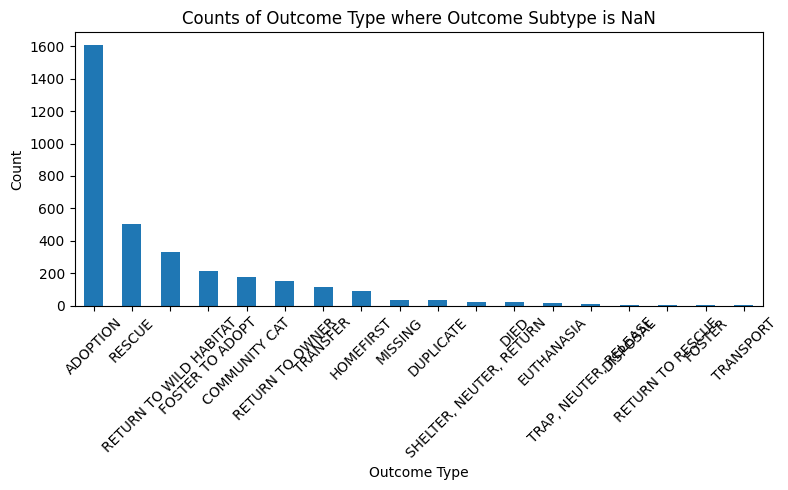

In [43]:
# Get the counts
counts = df[df['outcome_subtype'].isnull()]['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type where Outcome Subtype is NaN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Adding *intake_month*

In [44]:
df['intake_month'] = df['intake_date'].dt.month

## Adding *is_fixed* column

In [45]:
df['is_fixed'] = df['sex'].str.contains('Spayed|Neutered', case=False, na=False).astype(int)

## Making changes to the *sex* column

Since the sex column contains the fix status, we want to change that to just male, female, and unknown options. The way we can do that is by changing "neutered" to male and "spayed" to female

In [46]:
df['sex'] = df['sex'].replace({'Neutered': 'Male', 'Spayed': 'Female'})

# Observations, changes, & notes

1. Drop the following columns: *reason*, *geopoint*, *was_outcome_alive*, *animal_id*
2. Add a *has_name* column, then drop *animal_name*
3. Replace null values in *secondary_color* to "None" so that data for animals with more colours is preserved
4. Drop missing values for *outcome_type*, *intake_subtype*, 
5. Replace missing values in *outcome_subtype* to most commonly occuring values, **after more exploration**
6. Once incorporated into LUCA, drop *latitude*, *longitude*. Use *jurisdiction*
7. Drop *crossing*, unless it helps in geospatial mapping
8. Add a *time_to_outcome* variable
9. Convert *dob*, *intake_date*, *outcome_date* to datetime
10. *outcome_date*, and *outcome_type* have values missing together. Some values in *outcome_subtype* also miss when *outcome_type* is missing.
11. Since target variable is *outcome_type*, dropping *outcome_subtype* makes sense
12. If *outcome_type* is target, remove forward looking variables like *outcome_subtype*, *time_to_outcome*, *outcome_is_dead*, *outcome_date*, 
13. Add *time_at_shelter* but carefully so as to not leak forward looking information
14. Bucket *animal_type* into cat, dog, other
15. Add *age_at_intake* column
16. Add *age_at_outcome* column

# EDA pt. 2

## Average/Median time to outcome grouped by outcome type

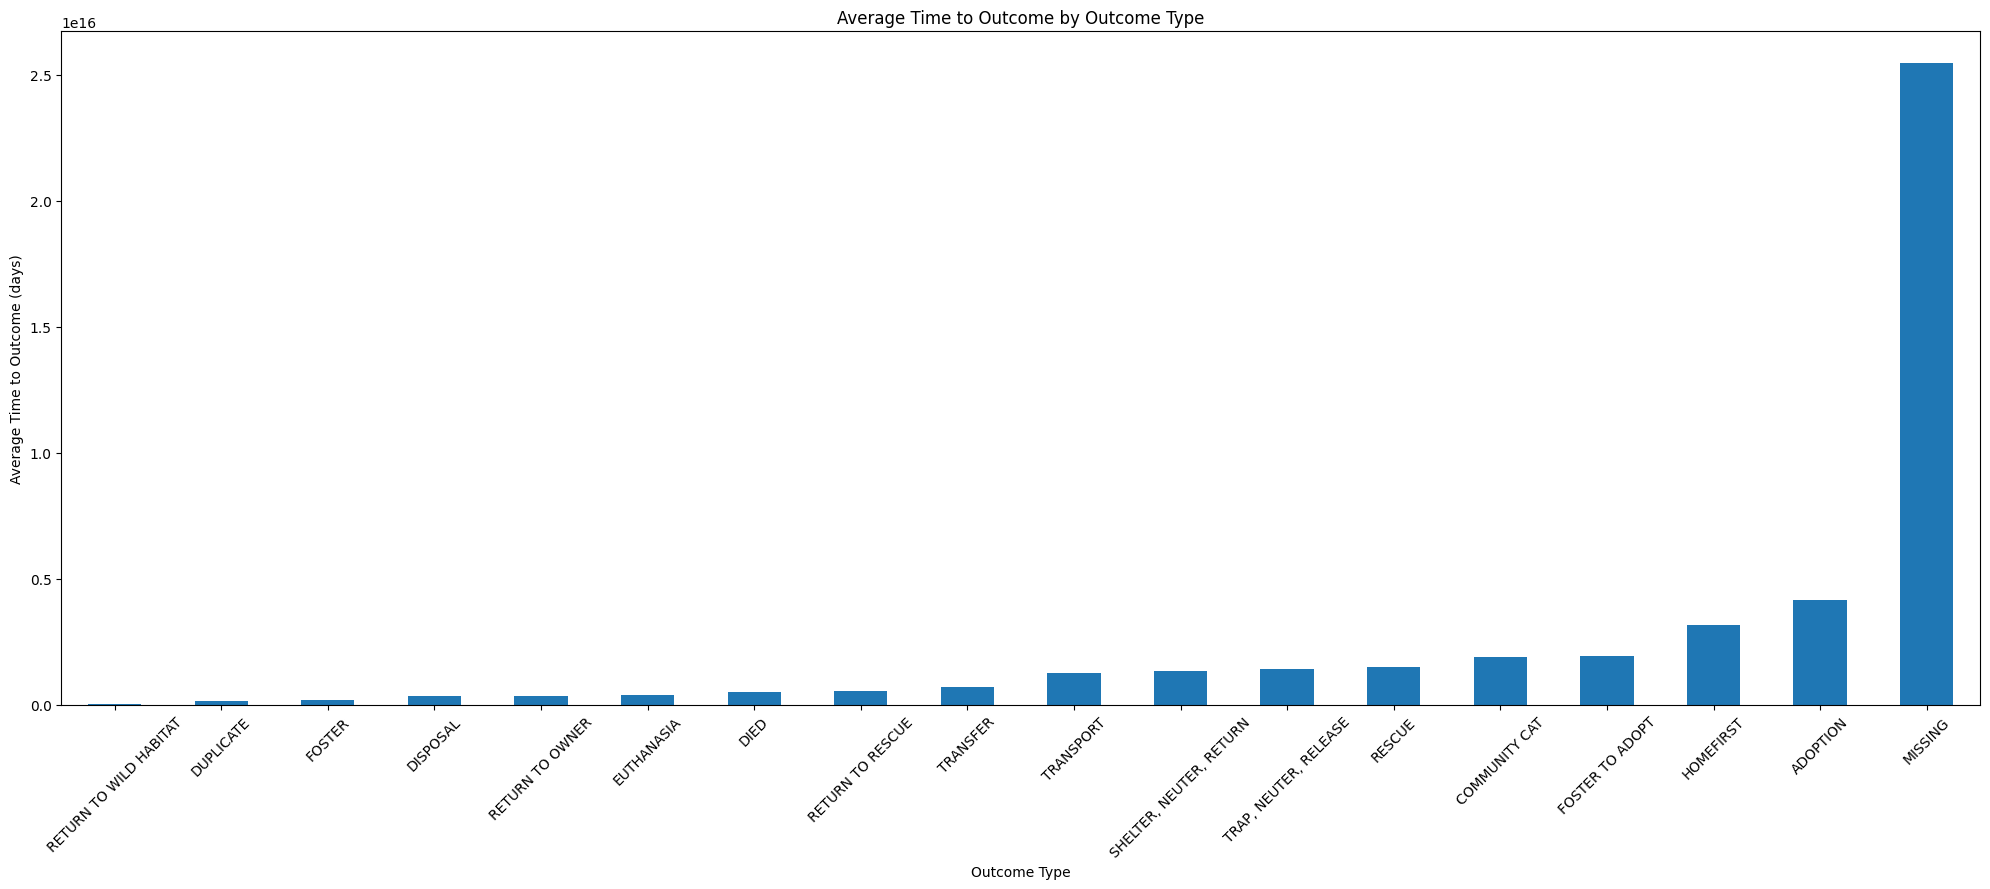

In [47]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].mean().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

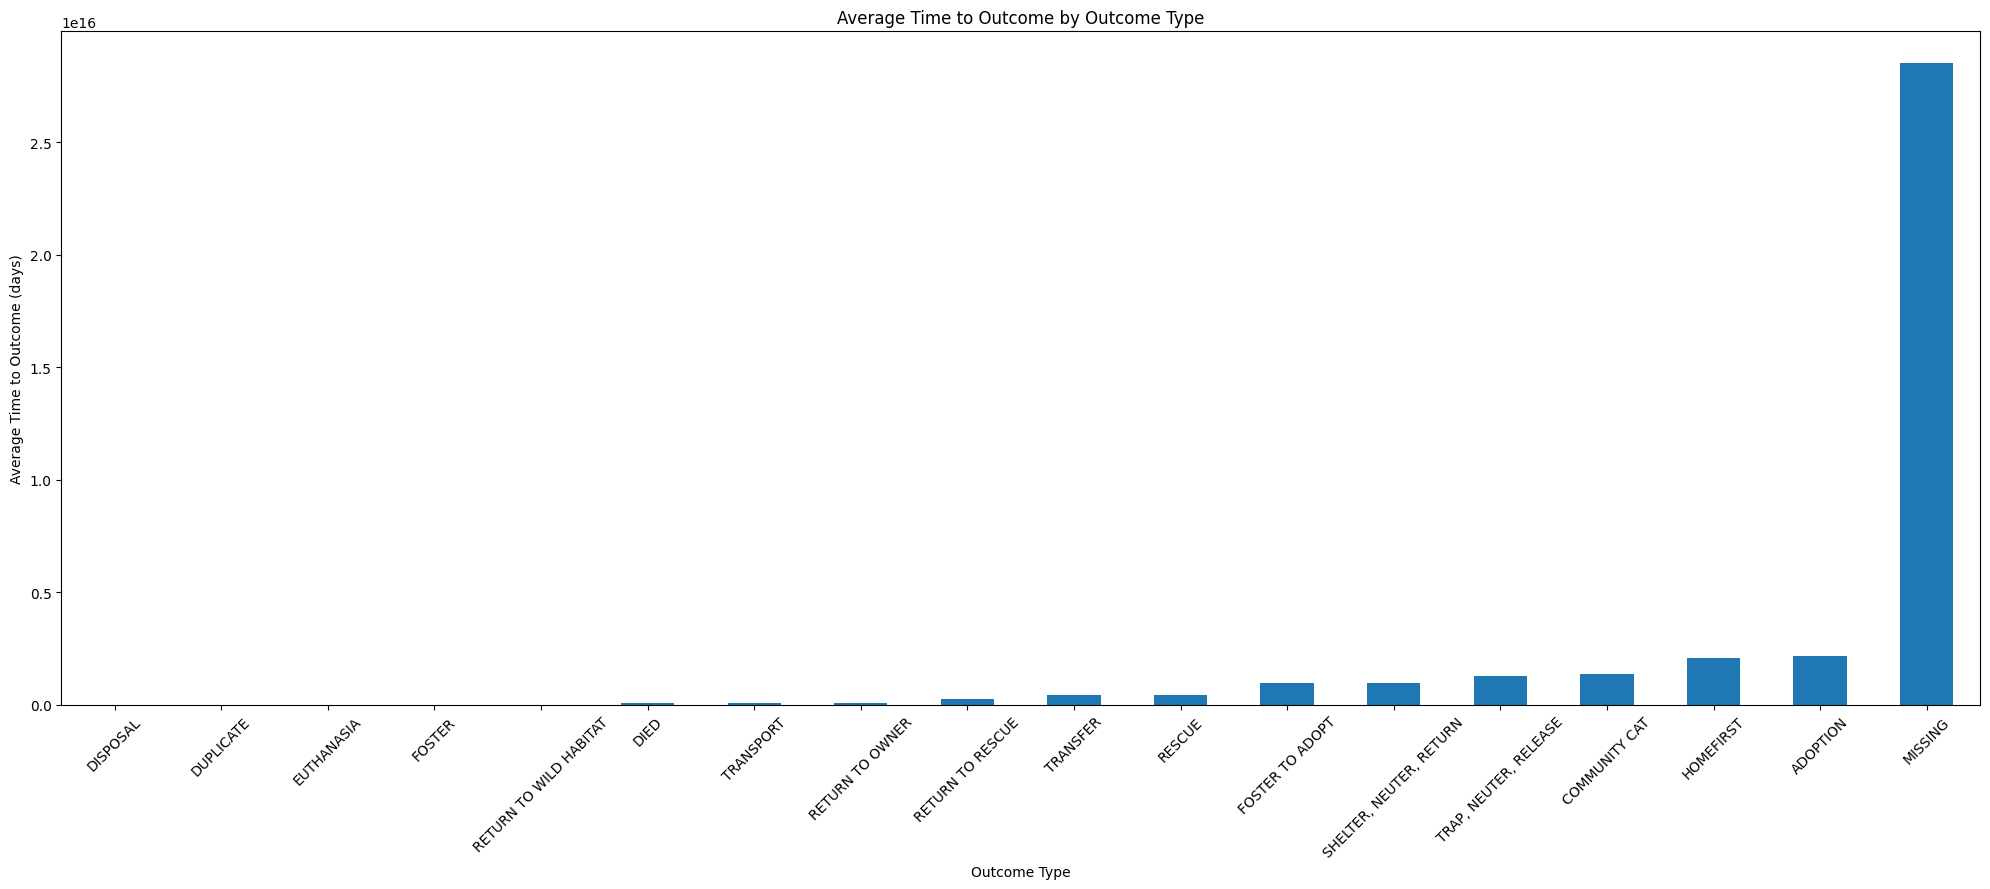

In [48]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].median().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df.head()

,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,outcome_date,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,intake_duration,is_current_month,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,intake_month,is_fixed
16409,DOG,TRICOLOR,None,Female,2006-08-21,2021-06-11,AGED,STRAY,FIELD,2021-06-12,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1.0,0,1 days,1,0,0,-1.0,First Visit,5408,1,6,1
18146,DOG,WHITE,None,Female,2008-12-09,2017-07-02,NORMAL,CONFISCATE,POLICE,2017-07-03,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1.0,0,1 days,1,0,0,-1.0,First Visit,3127,1,7,1
1222,OTHER,GRAY,None,Unknown,2022-04-04,2022-05-16,ILL MODERATETE,WILDLIFE,FIELD,2022-05-17,LONG BEACH,RESCUE,IBR,33.782031,-118.122403,False,1.0,0,1 days,1,0,0,-1.0,First Visit,42,0,5,0
25146,DOG,BLACK,TAN,Female,2005-11-19,2017-11-18,ILL MILD,STRAY,FIELD,2017-11-19,LONG BEACH,RETURN TO OWNER,WALKIN,33.769738,-118.181894,False,1.0,0,1 days,1,0,0,-1.0,First Visit,4382,1,11,1
9682,DOG,BR BRINDLE,WHITE,Female,2008-03-05,2018-03-05,NORMAL,OWNER SURRENDER,FIELD,2018-04-09,LONG BEACH,EUTHANASIA,BEH MODERA,33.852426,-118.185916,True,35.0,0,35 days,1,0,0,-1.0,First Visit,3652,1,3,0


## Unique value counts for each column

In [50]:
unique_counts_df = df.nunique().reset_index()
unique_counts_df.columns = ['column', 'unique_value_count']
print(unique_counts_df)

                   column  unique_value_count
0             animal_type                  10
1           primary_color                  83
2         secondary_color                  49
3                     sex                   3
4                     dob                5939
5             intake_date                3076
6             intake_cond                  17
7             intake_type                   9
8          intake_subtype                  24
9            outcome_date                3058
10           jurisdiction                  25
11           outcome_type                  18
12        outcome_subtype                 246
13               latitude                9622
14              longitude                9498
15        outcome_is_dead                   2
16        intake_duration                 370
17       is_current_month                   2
18        time_to_outcome                 370
19            visit_count                   8
20        is_return_visit         

## Null value count

In [51]:
df.isnull().sum()

animal_type                 0
primary_color               0
secondary_color             0
sex                         0
dob                         0
intake_date                 0
intake_cond                 0
intake_type                 0
intake_subtype              0
outcome_date                0
jurisdiction                1
outcome_type                0
outcome_subtype          3325
latitude                    0
longitude                   0
outcome_is_dead             0
intake_duration             0
is_current_month            0
time_to_outcome             0
visit_count                 0
is_return_visit             0
is_frequent_returner        0
days_since_last_visit       0
previous_outcome_type       0
age_at_intake_days          0
has_name                    0
intake_month                0
is_fixed                    0
dtype: int64

# Data cleaning pt. 3

## Datetime feature engineering using fastai

In [52]:
# 1. Make sure your columns are actual datetimes
for col in ['dob','intake_date','outcome_date']:
    df[col] = pd.to_datetime(df[col], utc=True)

# 2. Explode each date column into date‐parts + an “Elapsed” (epoch seconds)
for col in ['dob','intake_date','outcome_date']:
    add_datepart(df, col, drop=True)  # drop=True removes the original datetime

## Dropping redundant date columns

intake_month, intake_Year, intake_Month, intake_Week, intake_Day, intake_Dayofyear, intake_Is_month_end, intake_Is_month_start, intake_Is_quarter_end,intake_Is_quarter_start, intake_Is_year_end, intake_Is_year_start, outcome_Year, outcome_Month, outcome_Week, outcome_Day, outcome_Dayofyear, outcome_Is_month_end, outcome_Is_month_start, outcome_Is_quarter_end, outcome_Is_quarter_start, outcome_Is_year_end, outcome_Is_year_start, dobYear, dobMonth, dobWeek, dobDayd, obIs_month_end, dobIs_month_start, dobIs_quarter_end, dobIs_quarter_start, dobIs_year_end, dobIs_year_start

In [53]:
# Drop these columns: intake_month, intake_Year, intake_Month, intake_Week, intake_Day, intake_Dayofyear, intake_Is_month_end, intake_Is_month_start, intake_Is_quarter_end,intake_Is_quarter_start, intake_Is_year_end, intake_Is_year_start, outcome_Year, outcome_Month, outcome_Week, outcome_Day, outcome_Dayofyear, outcome_Is_month_end, outcome_Is_month_start, outcome_Is_quarter_end, outcome_Is_quarter_start, outcome_Is_year_end, outcome_Is_year_start, dobYear, dobMonth, dobWeek, dobDayd, obIs_month_end, dobIs_month_start, dobIs_quarter_end, dobIs_quarter_start, dobIs_year_end, dobIs_year_start
df = df.drop(columns=['intake_month', 'intake_Year', 'intake_Week', 'intake_Day', 'intake_Dayofyear', 'intake_Is_month_end', 'intake_Is_month_start', 'intake_Is_quarter_end', 'intake_Is_quarter_start', 'intake_Is_year_end', 'intake_Is_year_start', 'outcome_Year','outcome_Week', 'outcome_Day', 'outcome_Dayofyear', 'outcome_Is_month_end', 'outcome_Is_month_start', 'outcome_Is_quarter_end', 'outcome_Is_quarter_start', 'outcome_Is_year_end', 'outcome_Is_year_start', 'dobYear', 'dobWeek', 'dobDay', 'dobIs_month_end', 'dobIs_month_start', 'dobIs_quarter_end', 'dobIs_quarter_start', 'dobIs_year_end', 'dobIs_year_start', 'dobDayofyear'])

In [54]:
df.head()

,animal_type,primary_color,secondary_color,sex,intake_cond,intake_type,intake_subtype,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,intake_duration,is_current_month,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,is_fixed,dobMonth,dobDayofweek,dobElapsed,intake_Month,intake_Dayofweek,intake_Elapsed,outcome_Month,outcome_Dayofweek,outcome_Elapsed
16409,DOG,TRICOLOR,None,Female,AGED,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1.0,0,1 days,1,0,0,-1.0,First Visit,5408,1,1,8,0,1.156118e+09,6,4,1.623370e+09,6,5,1.623456e+09
18146,DOG,WHITE,None,Female,NORMAL,CONFISCATE,POLICE,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1.0,0,1 days,1,0,0,-1.0,First Visit,3127,1,1,12,1,1.228781e+09,7,6,1.498954e+09,7,0,1.499040e+09
1222,OTHER,GRAY,None,Unknown,ILL MODERATETE,WILDLIFE,FIELD,LONG BEACH,RESCUE,IBR,33.782031,-118.122403,False,1.0,0,1 days,1,0,0,-1.0,First Visit,42,0,0,4,0,1.649030e+09,5,0,1.652659e+09,5,1,1.652746e+09
25146,DOG,BLACK,TAN,Female,ILL MILD,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.769738,-118.181894,False,1.0,0,1 days,1,0,0,-1.0,First Visit,4382,1,1,11,5,1.132358e+09,11,5,1.510963e+09,11,6,1.511050e+09
9682,DOG,BR BRINDLE,WHITE,Female,NORMAL,OWNER SURRENDER,FIELD,LONG BEACH,EUTHANASIA,BEH MODERA,33.852426,-118.185916,True,35.0,0,35 days,1,0,0,-1.0,First Visit,3652,1,0,3,2,1.204675e+09,3,0,1.520208e+09,4,0,1.523232e+09


## Correlation plot

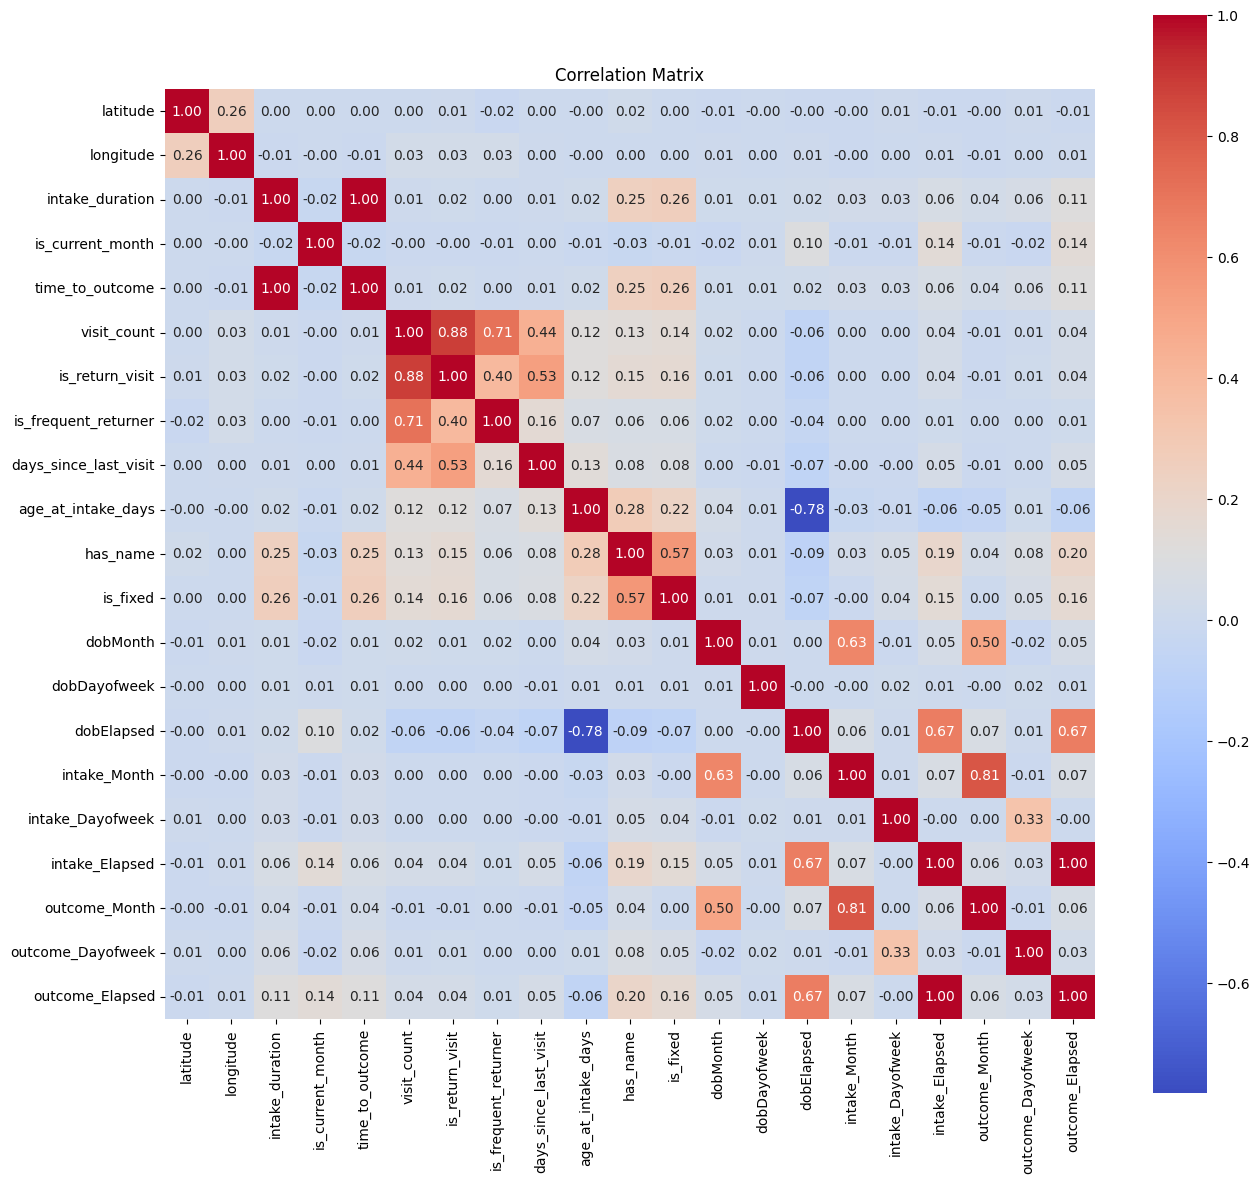

In [55]:
# Compute the correlation matrix (only numeric columns)
corr = df.select_dtypes(include='number').corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(15, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31844 entries, 16409 to 11598
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            31844 non-null  object         
 1   primary_color          31844 non-null  object         
 2   secondary_color        31844 non-null  object         
 3   sex                    31844 non-null  object         
 4   intake_cond            31844 non-null  object         
 5   intake_type            31844 non-null  object         
 6   intake_subtype         31844 non-null  object         
 7   jurisdiction           31843 non-null  object         
 8   outcome_type           31844 non-null  object         
 9   outcome_subtype        28519 non-null  object         
 10  latitude               31844 non-null  float64        
 11  longitude              31844 non-null  float64        
 12  outcome_is_dead        31844 non-null  bool    

## High cardinality check

In [57]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_unique_counts = df[cat_cols].nunique()
print(cat_unique_counts.sort_values(ascending=False))

outcome_subtype          246
primary_color             83
secondary_color           49
jurisdiction              25
intake_subtype            24
outcome_type              18
intake_cond               17
previous_outcome_type     16
animal_type               10
intake_type                9
sex                        3
dtype: int64


Features with high cardinality to fix:
1. primary_color
2. secondary_color
3. outcome_type (bucket into fewer outcomes)
4. animal_type (bucket into cat, dog, other outcomes)

## List unique values for feature engineering

In [58]:
# List of unique values for primary_color
primary_colour_unique = df['primary_color'].unique()
print(primary_colour_unique)

['TRICOLOR' 'WHITE' 'GRAY' 'BLACK' 'BR BRINDLE' 'TAN' 'CHOCOLATE' 'RED'
 'BUFF' 'BLONDE' 'YELLOW' 'BROWN' 'CREAM' 'GOLD' 'BLUE MERLE' 'BLUE'
 'ORANGE' 'BLK SMOKE' 'FLAME PT' 'GRAY TABBY' 'SABLE' 'TORTIE'
 'BL BRINDLE' 'RED MERLE' 'WHEAT' 'BRN TABBY' 'FAWN' 'ORG TABBY'
 'TORTIE MUT' 'TORTIE DIL' 'APRICOT' 'BLUE BRIND' 'SEAL PT' 'CALICO DIL'
 'SILVER' 'CRM TABBY' 'BLUE PT' 'CALICO' 'GREEN' 'SLVR TABBY' 'CALICO PT'
 'CALICO TAB' 'SNOWSHOE' 'CHOC PT' 'LYNX PT' 'LI LYNX PT' 'LC LYNX PT'
 'LIVER' 'BC LYNX PT' 'PINK' 'BLK TABBY' 'LILAC PT' 'BRN MERLE'
 'TORTIE PT' 'SEAL' 'BLUE TICK' 'Y BRINDLE' 'S-T PT' 'SL LYNX PT' 'TORBI'
 'DAPPLE' 'ORG TIGER' 'BLUE CREAM' 'GRAY TIGER' 'UNKNOWN' 'BRN TIGER'
 'RUDDY' 'PEACH' 'CR LYNX PT' 'BL LYNX PT' 'BLUE TABBY' 'L-C PT'
 'BLK TIGER' 'CREAM PT' 'C-T PT' 'CRM TIGER' 'B-C PT' 'LIVER TICK'
 'ST LYNX PT' 'BLUE FAWN' 'CH LYNX PT' 'RED PT' 'CT LYNX PT']


In [59]:
# List of unique values for secondary_color
secondary_colour_unique = df['secondary_color'].unique()
print(secondary_colour_unique)

['None' 'TAN' 'WHITE' 'ORANGE' 'BROWN' 'BLACK' 'GRAY' 'GOLD' 'RED' 'BLUE'
 'BRN TABBY' 'SILVER' 'TORTIE' 'BL BRINDLE' 'BR BRINDLE' 'YELLOW' 'GREEN'
 'CREAM' 'CALICO' 'GRAY TABBY' 'ORG TABBY' 'PINK' 'TRICOLOR' 'FLAME PT'
 'PURPLE' 'LYNX PT' 'APRICOT' 'CHOCOLATE' 'BLK SMOKE' 'TORTIE DIL'
 'SLVR TABBY' 'FAWN' 'TORBI' 'CRM TABBY' 'BLK TIGER' 'BLUE PT' 'BRN MERLE'
 'BLK TABBY' 'SABLE' 'CALICO PT' 'WHEAT' 'MARBLED TABBY' 'PEACH'
 'LILAC PT' 'CALICO TABBY' 'RED MERLE' 'SEAL' 'BLUE TICK' 'RED TICK']


In [60]:
outcome_type_unique = df['outcome_type'].unique()
print(outcome_type_unique)

['RETURN TO OWNER' 'RESCUE' 'EUTHANASIA' 'TRANSPORT' 'DUPLICATE'
 'TRANSFER' 'ADOPTION' 'DIED' 'COMMUNITY CAT' 'SHELTER, NEUTER, RETURN'
 'RETURN TO WILD HABITAT' 'RETURN TO RESCUE' 'MISSING' 'DISPOSAL' 'FOSTER'
 'FOSTER TO ADOPT' 'TRAP, NEUTER, RELEASE' 'HOMEFIRST']


In [61]:
animal_type_unique = df['animal_type'].unique()
print(animal_type_unique)

['DOG' 'OTHER' 'CAT' 'RABBIT' 'REPTILE' 'BIRD' 'LIVESTOCK' 'WILD'
 'GUINEA PIG' 'AMPHIBIAN']


## Dealing with high cardinality 

### primary_color

In [62]:
def extract_base_color_and_pattern(color):
    """Extract base color and pattern information from primary color"""
    color = str(color).upper().strip()
    
    # Define pattern keywords
    pattern_keywords = ['TABBY', 'BRINDLE', 'MERLE', 'PT', 'POINT', 'SMOKE', 'TIGER', 'LYNX']
    
    # Check if it has a pattern
    has_pattern = any(keyword in color for keyword in pattern_keywords)
    
    # Extract base color
    if color in ['TRICOLOR', 'CALICO', 'CALICO DIL', 'CALICO PT', 'CALICO TAB']:
        base_color = 'Multicolor'
    elif 'BLACK' in color or 'BLK' in color:
        base_color = 'Black'
    elif 'WHITE' in color:
        base_color = 'White'
    elif 'BROWN' in color or 'BRN' in color or 'BR ' in color:
        base_color = 'Brown'
    elif 'GRAY' in color or 'GREY' in color:
        base_color = 'Gray'
    elif 'RED' in color or 'RD ' in color:
        base_color = 'Red'
    elif 'BLUE' in color or 'BL ' in color or 'BC ' in color:
        base_color = 'Blue'
    elif 'CREAM' in color or 'CRM' in color or 'CR ' in color:
        base_color = 'Cream'
    elif 'TAN' in color:
        base_color = 'Tan'
    elif 'YELLOW' in color:
        base_color = 'Yellow'
    elif 'ORANGE' in color or 'ORG' in color:
        base_color = 'Orange'
    elif 'GOLD' in color:
        base_color = 'Gold'
    elif 'SILVER' in color or 'SLVR' in color or 'SL ' in color:
        base_color = 'Silver'
    elif 'CHOCOLATE' in color or 'CHOC' in color or 'CH ' in color:
        base_color = 'Chocolate'
    elif 'BUFF' in color:
        base_color = 'Buff'
    elif 'BLONDE' in color:
        base_color = 'Blonde'
    elif 'APRICOT' in color:
        base_color = 'Apricot'
    elif 'TORTIE' in color or 'TORBI' in color:
        base_color = 'Tortoiseshell'
    elif 'SABLE' in color:
        base_color = 'Sable'
    elif 'WHEAT' in color:
        base_color = 'Wheat'
    elif 'FAWN' in color:
        base_color = 'Fawn'
    elif 'SEAL' in color:
        base_color = 'Seal'
    elif 'LILAC' in color:
        base_color = 'Lilac'
    elif 'LIVER' in color:
        base_color = 'Liver'
    elif 'PINK' in color:
        base_color = 'Pink'
    elif 'GREEN' in color:
        base_color = 'Green'
    elif 'FLAME' in color:
        base_color = 'Flame'
    elif 'PEACH' in color:
        base_color = 'Peach'
    elif 'RUDDY' in color:
        base_color = 'Ruddy'
    elif 'DAPPLE' in color:
        base_color = 'Dapple'
    elif 'SNOWSHOE' in color:
        base_color = 'Snowshoe'
    elif 'TICK' in color:
        base_color = 'Tick'
    elif 'UNKNOWN' in color:
        base_color = 'Unknown'
    else:
        base_color = 'Other'
    
    return base_color, int(has_pattern)

# Apply transformation
print("Extracting base colors and patterns...")
primary_color_info = df['primary_color'].apply(extract_base_color_and_pattern)
df['primary_base_color'] = [info[0] for info in primary_color_info]
df['has_pattern'] = [info[1] for info in primary_color_info]

# Display results
print("Primary color transformation results:")
print(f"primary_base_color unique values: {df['primary_base_color'].nunique()}")
print("Base color distribution:")
print(df['primary_base_color'].value_counts().head(10))
print(f"\nPattern distribution:")
print(df['has_pattern'].value_counts())

Extracting base colors and patterns...
Primary color transformation results:
primary_base_color unique values: 33
Base color distribution:
primary_base_color
Black            8124
Brown            6491
Gray             5464
White            3948
Tan              1555
Orange           1485
Multicolor       1123
Tortoiseshell     669
Blue              379
Cream             346
Name: count, dtype: int64

Pattern distribution:
has_pattern
0    26103
1     5741
Name: count, dtype: int64


### secondary_color

In [63]:
# Create binary secondary color feature
df['has_secondary_color'] = (df['secondary_color'] != 'None').astype(int)

print("Secondary color transformation results:")
print("has_secondary_color distribution:")
print(df['has_secondary_color'].value_counts())
print(f"Percentage with secondary color: {df['has_secondary_color'].mean()*100:.1f}%")

print("\n" + "="*60)
print("TRANSFORMING ANIMAL TYPE")
print("="*60)

Secondary color transformation results:
has_secondary_color distribution:
has_secondary_color
0    16573
1    15271
Name: count, dtype: int64
Percentage with secondary color: 48.0%

TRANSFORMING ANIMAL TYPE


### animal_type

In [64]:
def categorize_animal_type(animal_type):
    """Categorize animal type into Cat, Dog, Other"""
    animal_type = str(animal_type).upper().strip()
    
    if animal_type == 'CAT':
        return 'Cat'
    elif animal_type == 'DOG':
        return 'Dog'
    else:  # OTHER, RABBIT, REPTILE, BIRD, LIVESTOCK, WILD, GUINEA PIG
        return 'Other'

# Apply transformation
df['animal_type_grouped'] = df['animal_type'].apply(categorize_animal_type)

print("Animal type transformation results:")
print("Original vs. Grouped:")
print(pd.crosstab(df['animal_type'], df['animal_type_grouped'], margins=True))

print("\nGrouped animal type distribution:")
print(df['animal_type_grouped'].value_counts())

Animal type transformation results:
Original vs. Grouped:
animal_type_grouped    Cat    Dog  Other    All
animal_type                                    
AMPHIBIAN                0      0      2      2
BIRD                     0      0   2440   2440
CAT                  14919      0      0  14919
DOG                      0  10269      0  10269
GUINEA PIG               0      0    192    192
LIVESTOCK                0      0      9      9
OTHER                    0      0   1476   1476
RABBIT                   0      0    608    608
REPTILE                  0      0    367    367
WILD                     0      0   1562   1562
All                  14919  10269   6656  31844

Grouped animal type distribution:
animal_type_grouped
Cat      14919
Dog      10269
Other     6656
Name: count, dtype: int64


### outcome_type

In [65]:
def categorize_outcome_type(outcome_type):
    """Categorize outcome type into 6 main categories"""
    outcome_type = str(outcome_type).upper().strip()
    
    if outcome_type == 'RESCUE':
        return 'Rescue'
    elif outcome_type == 'ADOPTION':
        return 'Adoption'
    elif outcome_type == 'EUTHANASIA':
        return 'Euthanasia'
    elif outcome_type == 'TRANSFER':
        return 'Transfer'
    elif outcome_type == 'RETURN TO OWNER':
        return 'Return to Owner'
    else:  # All other outcomes go to 'Other'
        return 'Other'

# Apply transformation
df['outcome_type_grouped'] = df['outcome_type'].apply(categorize_outcome_type)

print("Outcome type transformation results:")
print("Original vs. Grouped mapping:")
outcome_mapping = df.groupby('outcome_type')['outcome_type_grouped'].first().sort_values()
for original, grouped in outcome_mapping.items():
    count = (df['outcome_type'] == original).sum()
    print(f"  {original} → {grouped} ({count:,} records)")

print("\nGrouped outcome type distribution:")
grouped_counts = df['outcome_type_grouped'].value_counts()
for outcome, count in grouped_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {outcome}: {count:,} ({percentage:.1f}%)")

Outcome type transformation results:
Original vs. Grouped mapping:
  ADOPTION → Adoption (6,616 records)
  EUTHANASIA → Euthanasia (5,878 records)
  SHELTER, NEUTER, RETURN → Other (948 records)
  RETURN TO WILD HABITAT → Other (330 records)
  RETURN TO RESCUE → Other (46 records)
  MISSING → Other (57 records)
  TRANSPORT → Other (317 records)
  HOMEFIRST → Other (92 records)
  FOSTER → Other (12 records)
  DUPLICATE → Other (32 records)
  DISPOSAL → Other (67 records)
  DIED → Other (745 records)
  COMMUNITY CAT → Other (436 records)
  FOSTER TO ADOPT → Other (215 records)
  TRAP, NEUTER, RELEASE → Other (8 records)
  RESCUE → Rescue (7,481 records)
  RETURN TO OWNER → Return to Owner (3,354 records)
  TRANSFER → Transfer (5,210 records)

Grouped outcome type distribution:
  Rescue: 7,481 (23.5%)
  Adoption: 6,616 (20.8%)
  Euthanasia: 5,878 (18.5%)
  Transfer: 5,210 (16.4%)
  Return to Owner: 3,354 (10.5%)
  Other: 3,305 (10.4%)


# Isolation forest

## Feature engineering

In [66]:
df['time_to_outcome_days'] = df['time_to_outcome'].dt.total_seconds() / (24 * 3600)

## Categorical columns

In [67]:
# Define categorical variables for encoding
categorical_columns = ['animal_type', 'primary_color', 'secondary_color', 'sex', 
                      'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction',
                      'outcome_type', 'previous_outcome_type']


In [68]:
# Label encode categorical variables
label_encoders = {}
df_encoded = df.copy()

In [69]:
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

## Selecting features for isolation forest

In [70]:
feature_columns = [
    # Encoded categorical features
    'animal_type_encoded', 'primary_color_encoded', 'secondary_color_encoded', 
    'sex_encoded', 'intake_cond_encoded', 'intake_type_encoded', 
    'intake_subtype_encoded', 'jurisdiction_encoded', 'outcome_type_encoded', 
    'previous_outcome_type_encoded',
    # Numerical features
    'latitude', 'longitude', 'outcome_is_dead', 'visit_count', 'is_return_visit',
    'is_frequent_returner', 'days_since_last_visit', 'age_at_intake_days',
    'has_name', 'is_fixed', 'dobMonth', 'dobDayofweek', 'dobElapsed',
    'intake_Month', 'intake_Dayofweek', 'intake_Elapsed', 'outcome_Month',
    'outcome_Dayofweek', 'outcome_Elapsed', 'time_to_outcome_days'
]

In [71]:
# Create feature matrix
X = df_encoded[feature_columns].copy()

In [72]:
# Convert boolean to int
X['outcome_is_dead'] = X['outcome_is_dead'].astype(int)

## Running isolation forest

Feature matrix shape: (31844, 30)
Features used: 30

Isolation Forest Results:
Total samples: 31844
Outliers detected: 319 (1.00%)
Inliers: 31525 (99.00%)


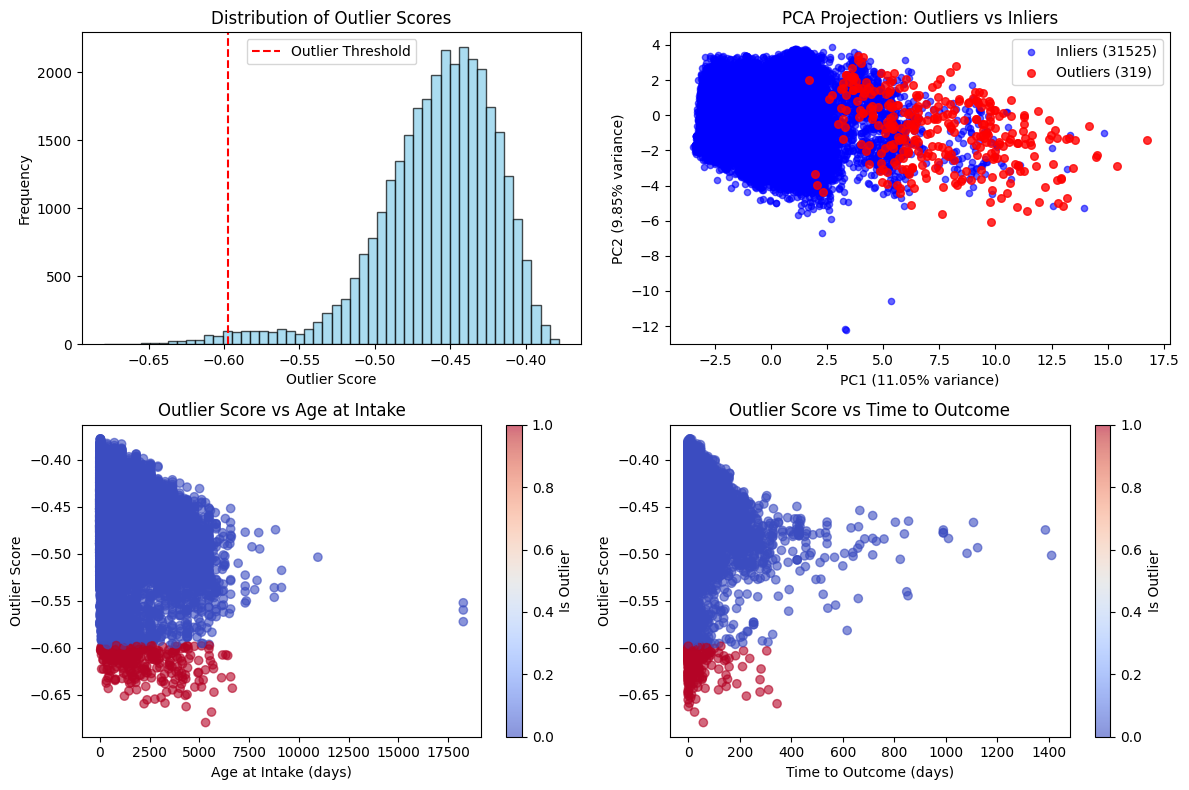


Top 10 Outliers (lowest scores):
      animal_type outcome_type  age_at_intake_days  time_to_outcome_days  visit_count  outlier_score
4376          DOG   EUTHANASIA                5314                  59.0            2      -0.679384
15292         DOG         DIED                5612                  25.0            2      -0.668227
5781          CAT   EUTHANASIA                4337                   1.0            3      -0.662491
14358         CAT     ADOPTION                2224                 345.0            2      -0.659394
5922          CAT   EUTHANASIA                3276                   5.0            2      -0.658714
19434         CAT   EUTHANASIA                2373                   0.0            3      -0.655246
26610         CAT   EUTHANASIA                2767                  30.0            2      -0.654460
1763          DOG       RESCUE                3079                  10.0            2      -0.652767
30449         DOG   EUTHANASIA                1238       

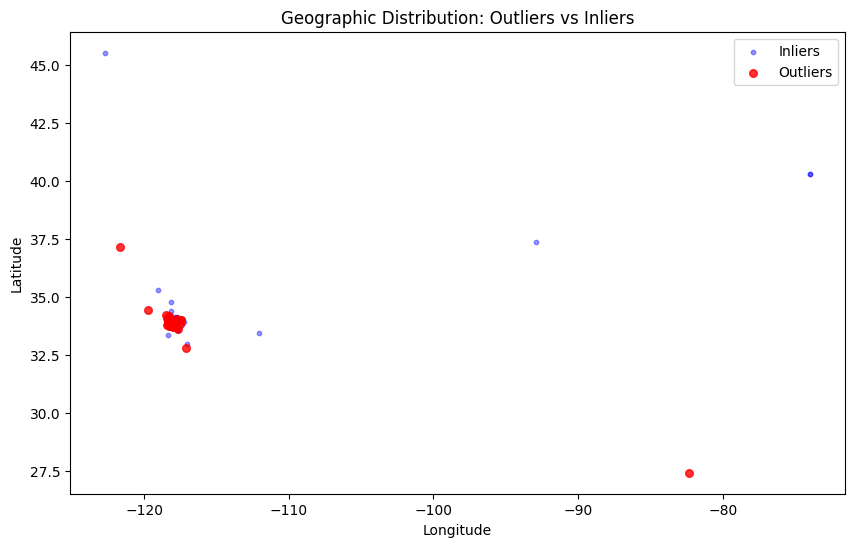


Isolation Forest completed!
Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns


In [73]:
print("Feature matrix shape:", X.shape)
print("Features used:", len(feature_columns))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest
# contamination parameter: expected proportion of outliers (adjust as needed)
isolation_forest = IsolationForest(
    contamination=0.01,  # Expect 5% outliers
    random_state=42,
    n_estimators=100
)

# Fit and predict
outlier_labels = isolation_forest.fit_predict(X_scaled)
outlier_scores = isolation_forest.score_samples(X_scaled)

# Add results to dataframe
df_encoded['outlier_label'] = outlier_labels
df_encoded['outlier_score'] = outlier_scores
df_encoded['is_outlier'] = (outlier_labels == -1)

# Print results summary
n_outliers = sum(outlier_labels == -1)
n_inliers = sum(outlier_labels == 1)
outlier_percentage = (n_outliers / len(df_encoded)) * 100

print(f"\nIsolation Forest Results:")
print(f"Total samples: {len(df_encoded)}")
print(f"Outliers detected: {n_outliers} ({outlier_percentage:.2f}%)")
print(f"Inliers: {n_inliers} ({100-outlier_percentage:.2f}%)")

# Visualization 1: Outlier Score Distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(outlier_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=outlier_scores[outlier_labels == -1].max(), color='red', 
           linestyle='--', label=f'Outlier Threshold')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.legend()

# Visualization 2: PCA projection for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.subplot(2, 2, 2)
inlier_mask = outlier_labels == 1
outlier_mask = outlier_labels == -1

plt.scatter(X_pca[inlier_mask, 0], X_pca[inlier_mask, 1], 
           c='blue', alpha=0.6, s=20, label=f'Inliers ({n_inliers})')
plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], 
           c='red', alpha=0.8, s=30, label=f'Outliers ({n_outliers})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Projection: Outliers vs Inliers')
plt.legend()

# Visualization 3: Outlier scores vs some key features
plt.subplot(2, 2, 3)
plt.scatter(df_encoded['age_at_intake_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Age at Intake (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Age at Intake')
plt.colorbar(label='Is Outlier')

plt.subplot(2, 2, 4)
plt.scatter(df_encoded['time_to_outcome_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Time to Outcome (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Time to Outcome')
plt.colorbar(label='Is Outlier')

plt.tight_layout()
plt.show()

# Additional analysis: Top outliers
print("\nTop 10 Outliers (lowest scores):")
top_outliers = df_encoded[df_encoded['is_outlier']].nsmallest(10, 'outlier_score')
print(top_outliers[['animal_type', 'outcome_type', 'age_at_intake_days', 
                   'time_to_outcome_days', 'visit_count', 'outlier_score']].to_string())

# Feature importance analysis (based on outlier characteristics)
print("\nOutlier vs Inlier Comparison (mean values):")
comparison_features = ['age_at_intake_days', 'time_to_outcome_days', 'visit_count', 
                      'days_since_last_visit', 'is_frequent_returner']

outlier_means = df_encoded[df_encoded['is_outlier']][comparison_features].mean()
inlier_means = df_encoded[~df_encoded['is_outlier']][comparison_features].mean()

comparison_df = pd.DataFrame({
    'Outliers': outlier_means,
    'Inliers': inlier_means,
    'Difference': outlier_means - inlier_means
})
print(comparison_df.round(2))

# Categorical feature analysis for outliers
print("\nCategorical Feature Distribution in Outliers:")
categorical_analysis = ['animal_type', 'outcome_type', 'intake_type']
for feature in categorical_analysis:
    print(f"\n{feature} distribution in outliers:")
    outlier_dist = df_encoded[df_encoded['is_outlier']][feature].value_counts().head()
    total_dist = df_encoded[feature].value_counts().head()
    print("Outliers:", outlier_dist.to_dict())
    print("Overall:", total_dist.to_dict())

# Geographic outliers visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_encoded[~df_encoded['is_outlier']]['longitude'], 
           df_encoded[~df_encoded['is_outlier']]['latitude'], 
           c='blue', alpha=0.4, s=10, label='Inliers')
plt.scatter(df_encoded[df_encoded['is_outlier']]['longitude'], 
           df_encoded[df_encoded['is_outlier']]['latitude'], 
           c='red', alpha=0.8, s=30, label='Outliers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution: Outliers vs Inliers')
plt.legend()
plt.show()

print(f"\nIsolation Forest completed!")
print(f"Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns")

# Clustering

For clustering, let's try 3 algorithms:
1. K-Prototype clustering: Great for hybrid data with categorical and numerical features
2. Hierarchical clustering with Gower distance: No need for encoding categorical features
3. DBSCAN with gower distance: Density based clustering option

## Preprocessing

In [103]:
df_cluster = df.copy()

In [104]:
df_cluster = df_cluster.drop(columns=['outcome_subtype','outcome_type','latitude', 'longitude'])

In [74]:
# Data preprocessing - Drop outcome-related features
features_to_drop = [
    'outcome_type', 'outcome_subtype', 'outcome_is_dead', 
    'time_to_outcome', 'time_to_outcome_days',
    'outcome_Month', 'outcome_Dayofweek', 'outcome_Elapsed'
]

# Keep all other features
df_cluster = df.drop(columns=[col for col in features_to_drop if col in df.columns], errors='ignore')

In [105]:
df_cluster = df_cluster[df_cluster['jurisdiction'].notna()]

In [106]:
# Identify categorical and numerical columns
categorical_cols = df_cluster.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_cluster.select_dtypes(include=['number', 'bool']).columns.tolist()

print(f"\nCategorical features ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical features ({len(numerical_cols)}):", numerical_cols)

# Prepare data for clustering
X_cluster = df_cluster.copy()

# Convert boolean columns to int for consistency
for col in X_cluster.columns:
    if X_cluster[col].dtype == 'bool':
        X_cluster[col] = X_cluster[col].astype(int)

# Update numerical columns list after boolean conversion
numerical_cols = X_cluster.select_dtypes(include=['number']).columns.tolist()

print(f"Final numerical features: {len(numerical_cols)}")
print(f"Final categorical features: {len(categorical_cols)}")


Categorical features (12): ['animal_type', 'primary_color', 'secondary_color', 'sex', 'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction', 'previous_outcome_type', 'primary_base_color', 'animal_type_grouped', 'outcome_type_grouped']
Numerical features (23): ['outcome_is_dead', 'intake_duration', 'is_current_month', 'time_to_outcome', 'visit_count', 'is_return_visit', 'is_frequent_returner', 'days_since_last_visit', 'age_at_intake_days', 'has_name', 'is_fixed', 'dobMonth', 'dobDayofweek', 'dobElapsed', 'intake_Month', 'intake_Dayofweek', 'intake_Elapsed', 'outcome_Month', 'outcome_Dayofweek', 'outcome_Elapsed', 'has_pattern', 'has_secondary_color', 'time_to_outcome_days']
Final numerical features: 23
Final categorical features: 12


## K-Prototype clustering

With 5000 samples only

In [87]:
# Sample 5000 rows for clustering (reproducible)
X_cluster_sample = X_cluster.sample(n=10000, random_state=42)

X_cluster_sample['time_to_outcome'] = X_cluster_sample['time_to_outcome'].dt.total_seconds()

k_range = range(2, 11)
kproto_silhouette_scores = []
kproto_costs = []
kproto_models = {}

# Determine categorical feature indices for K-Prototypes
categorical_indices = [X_cluster_sample.columns.get_loc(col) for col in categorical_cols]

print("Testing K-Prototypes with different cluster sizes on 10000-sample subset...")
for k in k_range:
    print(f"Testing K={k}...")
    
    # Fit K-Prototypes
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    cluster_labels = kproto.fit_predict(X_cluster_sample.values, categorical=categorical_indices)
    
    # Calculate silhouette score using Gower distance
    gower_dist = gower.gower_matrix(X_cluster_sample)
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
    
    kproto_silhouette_scores.append(silhouette_avg)
    kproto_costs.append(kproto.cost_)
    kproto_models[k] = (kproto, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}, Cost = {kproto.cost_:.2f}")

# Find optimal K for K-Prototypes
optimal_k_kproto = k_range[np.argmax(kproto_silhouette_scores)]
best_kproto_model, best_kproto_labels = kproto_models[optimal_k_kproto]

print(f"\nOptimal K for K-Prototypes: {optimal_k_kproto}")
print(f"Best Silhouette Score: {max(kproto_silhouette_scores):.4f}")

Testing K-Prototypes with different cluster sizes on 5000-sample subset...
Testing K=2...
K=2: Silhouette Score = 0.0660, Cost = 115936402489559400448.00
Testing K=3...
K=3: Silhouette Score = 0.0457, Cost = 73081959720900984832.00
Testing K=4...
K=4: Silhouette Score = 0.0256, Cost = 52339271301747589120.00
Testing K=5...
K=5: Silhouette Score = 0.0152, Cost = 41730206667337990144.00
Testing K=6...
K=6: Silhouette Score = 0.0077, Cost = 32873505472830214144.00
Testing K=7...
K=7: Silhouette Score = 0.0057, Cost = 27229001869952679936.00
Testing K=8...
K=8: Silhouette Score = 0.0034, Cost = 24400055222247415808.00
Testing K=9...
K=9: Silhouette Score = -0.0039, Cost = 21499716570045308928.00
Testing K=10...
K=10: Silhouette Score = -0.0055, Cost = 19262797926483161088.00

Optimal K for K-Prototypes: 2
Best Silhouette Score: 0.0660


## Gower distance matrix calculation

In [90]:
X_cluster['time_to_outcome'] = X_cluster['time_to_outcome'].dt.total_seconds()

In [91]:
print("\n" + "="*60)
print("COMPUTING GOWER DISTANCE MATRIX")
print("="*60)

print("Computing Gower distance matrix...")
# Sample data if too large (Gower distance computation can be memory intensive)
if len(X_cluster) > 10000:
    print(f"Sampling 10000 rows from {len(X_cluster)} for distance computation...")
    sample_indices = np.random.choice(len(X_cluster), 10000, replace=False)
    X_sample = X_cluster.iloc[sample_indices]
    gower_dist_matrix = gower.gower_matrix(X_sample)
else:
    X_sample = X_cluster
    sample_indices = np.arange(len(X_cluster))
    gower_dist_matrix = gower.gower_matrix(X_sample)

print(f"Gower distance matrix shape: {gower_dist_matrix.shape}")



COMPUTING GOWER DISTANCE MATRIX
Computing Gower distance matrix...
Sampling 10000 rows from 31843 for distance computation...
Gower distance matrix shape: (10000, 10000)


## DBSCAN

In [92]:
print("\n" + "="*60)
print("DBSCAN WITH GOWER DISTANCE")
print("="*60)

# Test different epsilon values for DBSCAN
epsilon_range = np.arange(0.1, 1.0, 0.1)
dbscan_silhouette_scores = []
dbscan_n_clusters = []
dbscan_models = {}

print("Testing DBSCAN with different epsilon values...")
for eps in epsilon_range:
    print(f"Testing eps={eps:.2f}...")
    
    # Fit DBSCAN with precomputed Gower distance
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='precomputed')
    cluster_labels = dbscan.fit_predict(gower_dist_matrix)
    
    # Count clusters (excluding noise points labeled as -1)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    dbscan_n_clusters.append(n_clusters)
    
    # Calculate silhouette score (only if we have more than 1 cluster)
    if n_clusters > 1:
        # Remove noise points for silhouette calculation
        mask = cluster_labels != -1
        if np.sum(mask) > 1:
            silhouette_avg = silhouette_score(gower_dist_matrix[mask][:, mask], 
                                            cluster_labels[mask], metric='precomputed')
        else:
            silhouette_avg = -1
    else:
        silhouette_avg = -1
    
    dbscan_silhouette_scores.append(silhouette_avg)
    dbscan_models[eps] = (dbscan, cluster_labels)
    
    print(f"eps={eps:.2f}: Clusters = {n_clusters}, Noise = {n_noise}, Silhouette = {silhouette_avg:.4f}")

# Find optimal epsilon for DBSCAN
valid_scores = [score for score in dbscan_silhouette_scores if score > -1]
if valid_scores:
    optimal_eps_idx = np.argmax(dbscan_silhouette_scores)
    optimal_eps = epsilon_range[optimal_eps_idx]
    best_dbscan_model, best_dbscan_labels = dbscan_models[optimal_eps]
    
    print(f"\nOptimal epsilon for DBSCAN: {optimal_eps:.2f}")
    print(f"Best Silhouette Score: {max(dbscan_silhouette_scores):.4f}")
    print(f"Number of clusters: {dbscan_n_clusters[optimal_eps_idx]}")
else:
    print("No valid DBSCAN clustering found with given epsilon range")


DBSCAN WITH GOWER DISTANCE
Testing DBSCAN with different epsilon values...
Testing eps=0.10...
eps=0.10: Clusters = 18, Noise = 2806, Silhouette = -0.2439
Testing eps=0.20...
eps=0.20: Clusters = 1, Noise = 15, Silhouette = -1.0000
Testing eps=0.30...
eps=0.30: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.40...
eps=0.40: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.50...
eps=0.50: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.60...
eps=0.60: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.70...
eps=0.70: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.80...
eps=0.80: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.90...
eps=0.90: Clusters = 1, Noise = 0, Silhouette = -1.0000

Optimal epsilon for DBSCAN: 0.10
Best Silhouette Score: -0.2439
Number of clusters: 18


## Hierarchical clustering

In [93]:
print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING WITH GOWER DISTANCE")
print("="*60)
k_range = range(2, 11)
# Perform hierarchical clustering with different numbers of clusters
hierarchical_silhouette_scores = []
hierarchical_models = {}

print("Testing Hierarchical clustering with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    # Fit Agglomerative Clustering with precomputed distance
    hierarchical = AgglomerativeClustering(n_clusters=k, metric='euclidean', 
                                         linkage='average')
    cluster_labels = hierarchical.fit_predict(gower_dist_matrix)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(gower_dist_matrix, cluster_labels, metric='precomputed')
    
    hierarchical_silhouette_scores.append(silhouette_avg)
    hierarchical_models[k] = (hierarchical, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal K for Hierarchical clustering
optimal_k_hierarchical = k_range[np.argmax(hierarchical_silhouette_scores)]
best_hierarchical_model, best_hierarchical_labels = hierarchical_models[optimal_k_hierarchical]

print(f"\nOptimal K for Hierarchical: {optimal_k_hierarchical}")
print(f"Best Silhouette Score: {max(hierarchical_silhouette_scores):.4f}")


HIERARCHICAL CLUSTERING WITH GOWER DISTANCE
Testing Hierarchical clustering with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.1948
Testing K=3...
K=3: Silhouette Score = 0.1566
Testing K=4...
K=4: Silhouette Score = 0.1507
Testing K=5...
K=5: Silhouette Score = 0.1839
Testing K=6...
K=6: Silhouette Score = 0.1696
Testing K=7...
K=7: Silhouette Score = 0.1474
Testing K=8...
K=8: Silhouette Score = 0.1409
Testing K=9...
K=9: Silhouette Score = 0.1293
Testing K=10...
K=10: Silhouette Score = 0.1288

Optimal K for Hierarchical: 2
Best Silhouette Score: 0.1948


## Visual insights from clustering


CREATING VISUALIZATIONS


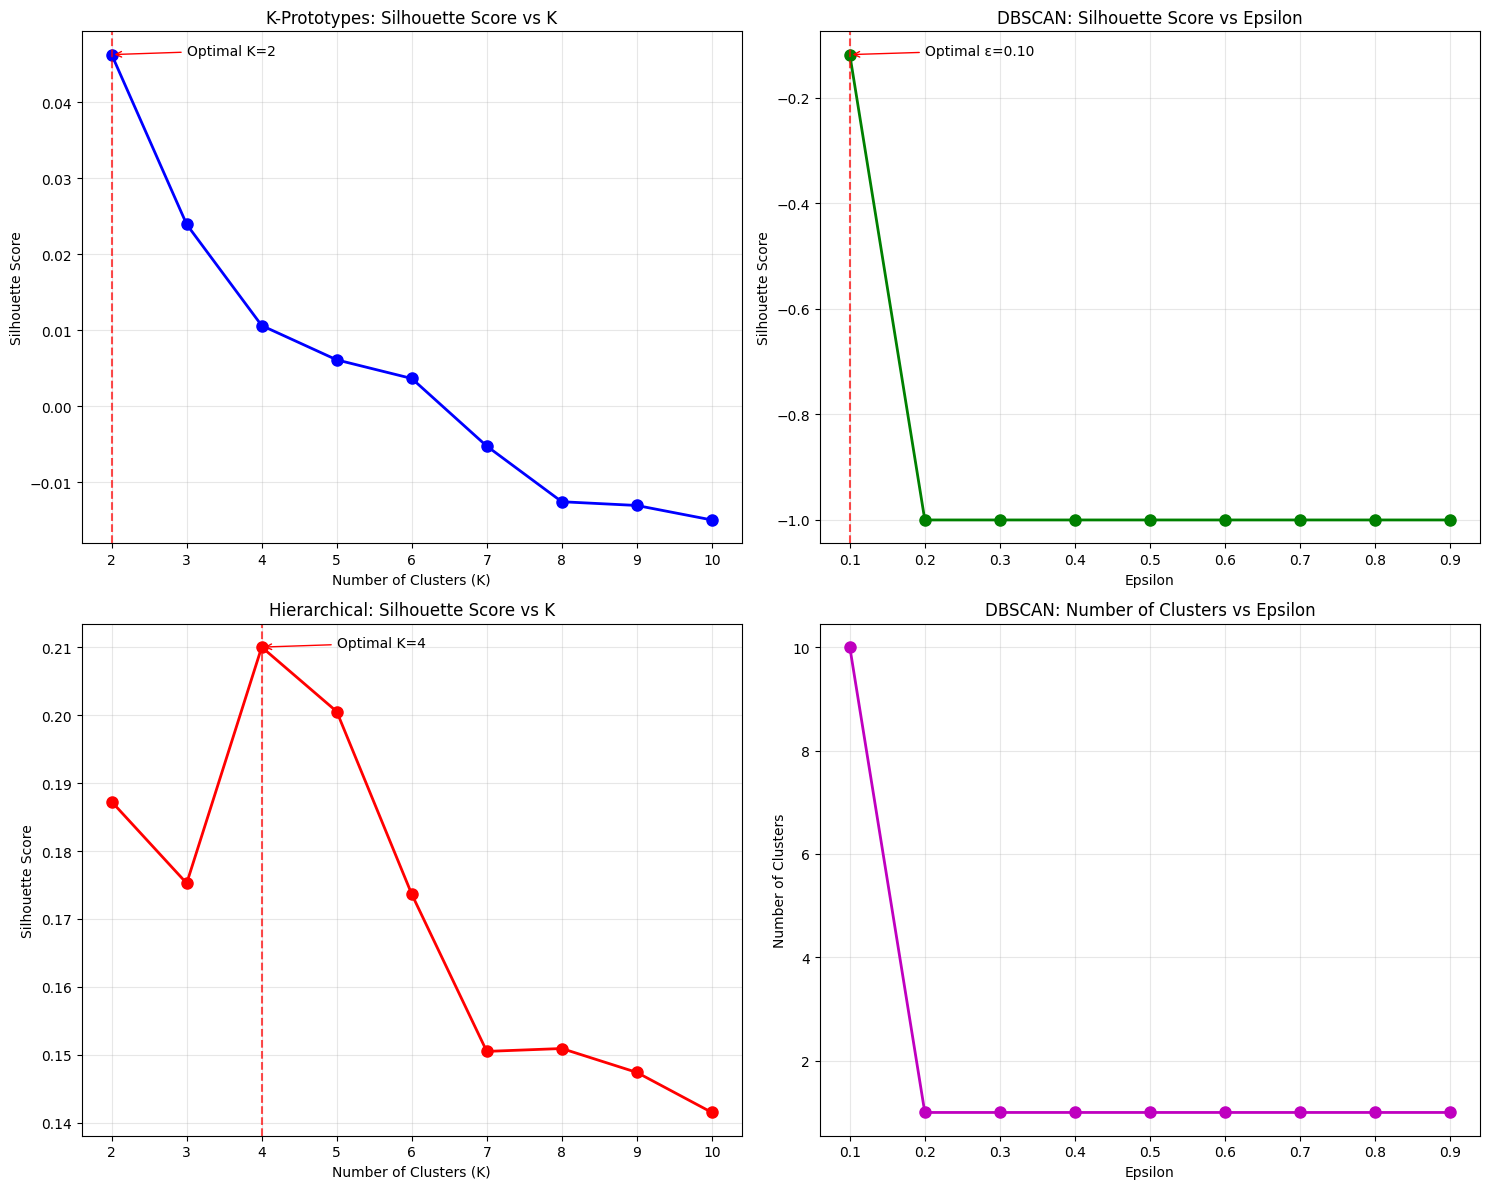

Creating PCA visualizations...


IndexError: index 30076 is out of bounds for axis 0 with size 10000

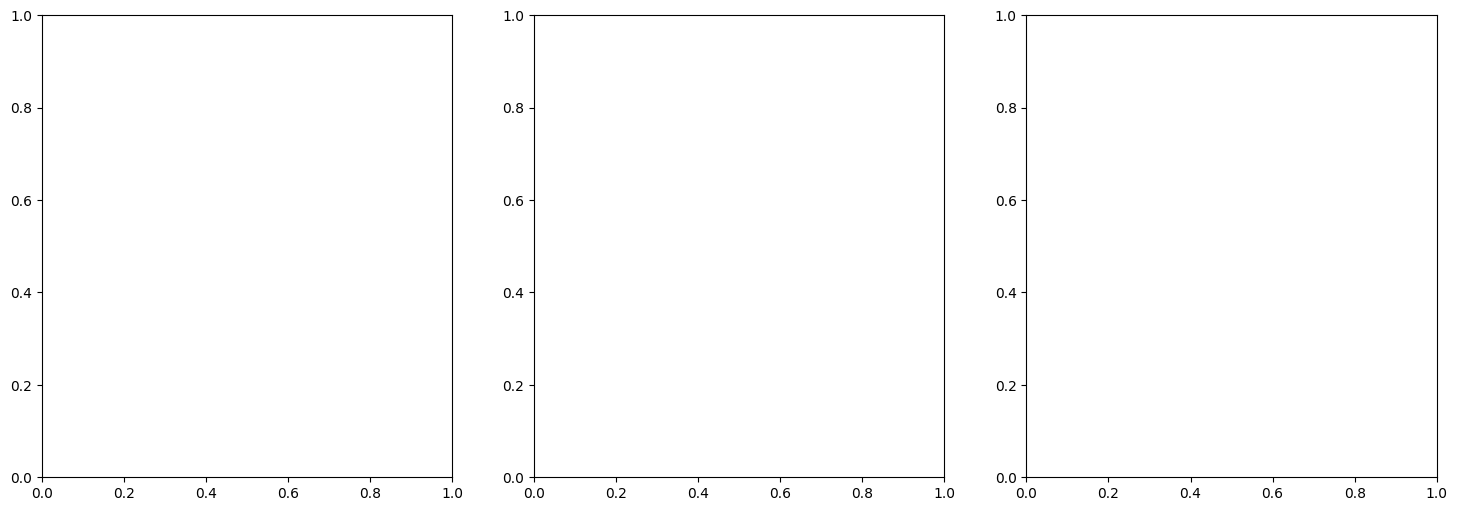

In [ ]:
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 1. Silhouette Score Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Prototypes Silhouette Scores
axes[0, 0].plot(k_range, kproto_silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=optimal_k_kproto, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('K-Prototypes: Silhouette Score vs K')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].annotate(f'Optimal K={optimal_k_kproto}', 
                   xy=(optimal_k_kproto, kproto_silhouette_scores[optimal_k_kproto-2]), 
                   xytext=(optimal_k_kproto+1, kproto_silhouette_scores[optimal_k_kproto-2]),
                   arrowprops=dict(arrowstyle='->', color='red'))

# DBSCAN Silhouette Scores
axes[0, 1].plot(epsilon_range, dbscan_silhouette_scores, 'go-', linewidth=2, markersize=8)
if valid_scores:
    axes[0, 1].axvline(x=optimal_eps, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].annotate(f'Optimal ε={optimal_eps:.2f}', 
                       xy=(optimal_eps, max(dbscan_silhouette_scores)), 
                       xytext=(optimal_eps+0.1, max(dbscan_silhouette_scores)),
                       arrowprops=dict(arrowstyle='->', color='red'))
axes[0, 1].set_xlabel('Epsilon')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('DBSCAN: Silhouette Score vs Epsilon')
axes[0, 1].grid(True, alpha=0.3)

# Hierarchical Silhouette Scores
axes[1, 0].plot(k_range, hierarchical_silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].axvline(x=optimal_k_hierarchical, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Hierarchical: Silhouette Score vs K')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].annotate(f'Optimal K={optimal_k_hierarchical}', 
                   xy=(optimal_k_hierarchical, hierarchical_silhouette_scores[optimal_k_hierarchical-2]), 
                   xytext=(optimal_k_hierarchical+1, hierarchical_silhouette_scores[optimal_k_hierarchical-2]),
                   arrowprops=dict(arrowstyle='->', color='red'))

# DBSCAN Number of Clusters vs Epsilon
axes[1, 1].plot(epsilon_range, dbscan_n_clusters, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Epsilon')
axes[1, 1].set_ylabel('Number of Clusters')
axes[1, 1].set_title('DBSCAN: Number of Clusters vs Epsilon')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. PCA Visualization of Clusters
print("Creating PCA visualizations...")

# Prepare data for PCA (encode categorical variables for PCA)
from sklearn.preprocessing import LabelEncoder
X_pca = X_sample.copy()
label_encoders = {}

for col in categorical_cols:
    if col in X_pca.columns:
        le = LabelEncoder()
        X_pca[col] = le.fit_transform(X_pca[col].astype(str))
        label_encoders[col] = le

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Create cluster visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Prototypes visualization (sample the labels to match PCA data)
if len(X_cluster) > 10000:
    kproto_labels_sample = best_kproto_labels[sample_indices]
else:
    kproto_labels_sample = best_kproto_labels

scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=kproto_labels_sample, cmap='tab10', alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'K-Prototypes Clusters (K={optimal_k_kproto})')
plt.colorbar(scatter1, ax=axes[0])

# DBSCAN visualization
if valid_scores:
    scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=best_dbscan_labels, cmap='tab10', alpha=0.6, s=30)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[1].set_title(f'DBSCAN Clusters (ε={optimal_eps:.2f})')
    plt.colorbar(scatter2, ax=axes[1])

# Hierarchical visualization
scatter3 = axes[2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=best_hierarchical_labels, cmap='tab10', alpha=0.6, s=30)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'Hierarchical Clusters (K={optimal_k_hierarchical})')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

# 3. Cluster Characteristics Analysis
print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*60)

# Add cluster labels to original dataframe for analysis
df_analysis = df_cluster.iloc[sample_indices].copy()
df_analysis['KPrototypes_Cluster'] = kproto_labels_sample
df_analysis['Hierarchical_Cluster'] = best_hierarchical_labels

if valid_scores:
    df_analysis['DBSCAN_Cluster'] = best_dbscan_labels

# Analyze K-Prototypes clusters
print("\nK-PROTOTYPES CLUSTER CHARACTERISTICS:")
print("-" * 50)

for cluster_id in sorted(df_analysis['KPrototypes_Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['KPrototypes_Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    # Categorical feature analysis
    print("Top categorical characteristics:")
    for cat_col in categorical_cols[:5]:  # Show top 5 categorical features
        if cat_col in cluster_data.columns:
            top_category = cluster_data[cat_col].mode().iloc[0]
            percentage = (cluster_data[cat_col] == top_category).mean() * 100
            print(f"  {cat_col}: {top_category} ({percentage:.1f}%)")
    
    # Numerical feature analysis
    print("Numerical characteristics:")
    for num_col in ['age_at_intake_days', 'visit_count', 'latitude', 'longitude'][:4]:
        if num_col in cluster_data.columns:
            mean_val = cluster_data[num_col].mean()
            print(f"  {num_col}: {mean_val:.2f}")

# Summary comparison
print("\n" + "="*60)
print("ALGORITHM PERFORMANCE SUMMARY")
print("="*60)

summary_data = {
    'Algorithm': ['K-Prototypes', 'Hierarchical', 'DBSCAN'],
    'Optimal_Params': [f'K={optimal_k_kproto}', f'K={optimal_k_hierarchical}', 
                      f'ε={optimal_eps:.2f}' if valid_scores else 'N/A'],
    'Silhouette_Score': [max(kproto_silhouette_scores), 
                        max(hierarchical_silhouette_scores),
                        max(dbscan_silhouette_scores) if valid_scores else 'N/A'],
    'N_Clusters': [optimal_k_kproto, optimal_k_hierarchical,
                  dbscan_n_clusters[optimal_eps_idx] if valid_scores else 'N/A']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\nClustering analysis completed!")
print("Best performing algorithm:", summary_df.loc[summary_df['Silhouette_Score'].idxmax(), 'Algorithm'] 
      if valid_scores else "K-Prototypes or Hierarchical")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30801 entries, 942 to 24785
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            30801 non-null  object         
 1   primary_color          30801 non-null  object         
 2   secondary_color        30801 non-null  object         
 3   sex                    30801 non-null  object         
 4   intake_cond            30801 non-null  object         
 5   intake_type            30801 non-null  object         
 6   intake_subtype         30801 non-null  object         
 7   jurisdiction           30801 non-null  object         
 8   outcome_type           30801 non-null  object         
 9   outcome_subtype        27579 non-null  object         
 10  latitude               30801 non-null  float64        
 11  longitude              30801 non-null  float64        
 12  outcome_is_dead        30801 non-null  bool      

## Preprocessing for K-Means & Spectral clustering

In [107]:
df_cluster['time_to_outcome'] = df_cluster['time_to_outcome'].dt.total_seconds()

In [108]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Reduce high-cardinality categorical features
print("Optimizing categorical features...")
for col in categorical_cols:
    value_counts = df_cluster[col].value_counts()
    if len(value_counts) > 15:  # If more than 15 categories
        # Keep top 10 categories, group rest as 'Other'
        top_categories = value_counts.head(10).index
        df_cluster[col] = df_cluster[col].apply(lambda x: x if x in top_categories else 'Other')
        print(f"Reduced {col} from {len(value_counts)} to {len(df_cluster[col].unique())} categories")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Fit and transform the data
print("Applying preprocessing pipeline...")
X_processed = preprocessor.fit_transform(df_cluster)
print(f"Processed feature matrix shape: {X_processed.shape}")

# Get feature names after preprocessing
feature_names = (numerical_cols + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))
print(f"Total features after encoding: {len(feature_names)}")


FEATURE ENGINEERING
Optimizing categorical features...
Reduced primary_color from 83 to 11 categories
Reduced secondary_color from 49 to 11 categories
Reduced intake_cond from 17 to 11 categories
Reduced intake_subtype from 24 to 11 categories
Reduced jurisdiction from 25 to 11 categories
Reduced previous_outcome_type from 16 to 11 categories
Reduced primary_base_color from 33 to 11 categories
Applying preprocessing pipeline...
Processed feature matrix shape: (31843, 119)
Total features after encoding: 119


## K-Means

In [109]:
print("\n" + "="*60)
print("K-MEANS CLUSTERING")
print("="*60)

# Test different K values
k_range = range(2, 9)  # Test K from 2 to 8
kmeans_silhouette_scores = []
kmeans_inertias = []
kmeans_models = {}

print("Testing K-Means with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_processed)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    inertia = kmeans.inertia_
    
    kmeans_silhouette_scores.append(silhouette_avg)
    kmeans_inertias.append(inertia)
    kmeans_models[k] = (kmeans, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}, Inertia = {inertia:.2f}")

# Find optimal K for K-Means
optimal_k_kmeans = k_range[np.argmax(kmeans_silhouette_scores)]
best_kmeans_model, best_kmeans_labels = kmeans_models[optimal_k_kmeans]

print(f"\nOptimal K for K-Means: {optimal_k_kmeans}")
print(f"Best Silhouette Score: {max(kmeans_silhouette_scores):.4f}")


K-MEANS CLUSTERING
Testing K-Means with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.0845, Inertia = 847458.94
Testing K=3...
K=3: Silhouette Score = 0.0939, Inertia = 779628.17
Testing K=4...
K=4: Silhouette Score = 0.0944, Inertia = 728918.01
Testing K=5...
K=5: Silhouette Score = 0.0995, Inertia = 685252.63
Testing K=6...
K=6: Silhouette Score = 0.0916, Inertia = 660811.77
Testing K=7...
K=7: Silhouette Score = 0.0972, Inertia = 628963.02
Testing K=8...
K=8: Silhouette Score = 0.1087, Inertia = 599004.27

Optimal K for K-Means: 8
Best Silhouette Score: 0.1087


## Affinity propagation

In [110]:
print("\n" + "="*60)
print("AFFINITY PROPAGATION")
print("="*60)

# Check computational feasibility
AP_SAMPLE_SIZE = 1000  # Reduce sample size for Affinity Propagation
if len(X_processed) > AP_SAMPLE_SIZE:
    print(f"Using {AP_SAMPLE_SIZE} samples for Affinity Propagation (computational efficiency)...")
    ap_indices = np.random.choice(len(X_processed), AP_SAMPLE_SIZE, replace=False)
    X_ap = X_processed[ap_indices]
    df_ap = df_cluster.iloc[ap_indices]
else:
    X_ap = X_processed
    ap_indices = np.arange(len(X_processed))
    df_ap = df_cluster

print("Testing Affinity Propagation...")
try:
    # Use different preference values (computationally efficient settings)
    preference_percentiles = [10, 25, 50]  # Test 3 preference values
    ap_silhouette_scores = []
    ap_n_clusters = []
    ap_models = {}
    
    for pref_pct in preference_percentiles:
        print(f"Testing preference at {pref_pct}th percentile...")
        
        # Calculate preference as percentile of pairwise distances
        from sklearn.metrics import euclidean_distances
        distances = euclidean_distances(X_ap[:min(500, len(X_ap))])  # Sample for preference calculation
        preference = np.percentile(distances, pref_pct) * -1
        
        # Fit Affinity Propagation with timeout protection
        ap = AffinityPropagation(preference=preference, random_state=42, 
                               max_iter=200, convergence_iter=15)
        
        cluster_labels = ap.fit_predict(X_ap)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if n_clusters > 1:
            silhouette_avg = silhouette_score(X_ap, cluster_labels)
        else:
            silhouette_avg = -1
        
        ap_silhouette_scores.append(silhouette_avg)
        ap_n_clusters.append(n_clusters)
        ap_models[pref_pct] = (ap, cluster_labels)
        
        print(f"Preference {pref_pct}%: Clusters = {n_clusters}, Silhouette = {silhouette_avg:.4f}")
    
    # Find best Affinity Propagation result
    if max(ap_silhouette_scores) > -1:
        optimal_pref_idx = np.argmax(ap_silhouette_scores)
        optimal_pref = preference_percentiles[optimal_pref_idx]
        best_ap_model, best_ap_labels = ap_models[optimal_pref]
        
        print(f"\nOptimal preference for AP: {optimal_pref}th percentile")
        print(f"Best Silhouette Score: {max(ap_silhouette_scores):.4f}")
        print(f"Number of clusters: {ap_n_clusters[optimal_pref_idx]}")
        ap_success = True
    else:
        print("Affinity Propagation failed to find valid clusters")
        ap_success = False

except Exception as e:
    print(f"Affinity Propagation failed: {str(e)}")
    ap_success = False


AFFINITY PROPAGATION
Using 1000 samples for Affinity Propagation (computational efficiency)...
Testing Affinity Propagation...
Testing preference at 10th percentile...
Preference 10%: Clusters = 947, Silhouette = 0.0312
Testing preference at 25th percentile...
Preference 25%: Clusters = 922, Silhouette = 0.0374
Testing preference at 50th percentile...
Preference 50%: Clusters = 884, Silhouette = 0.0448

Optimal preference for AP: 50th percentile
Best Silhouette Score: 0.0448
Number of clusters: 884


## Spectral clustering

In [111]:
print("\n" + "="*60)
print("SPECTRAL CLUSTERING")
print("="*60)

# Test different K values for Spectral Clustering
spectral_k_range = range(2, 7)  # Smaller range for computational efficiency
spectral_silhouette_scores = []
spectral_models = {}

print("Testing Spectral Clustering with different cluster sizes...")
for k in spectral_k_range:
    print(f"Testing K={k}...")
    
    try:
        # Use efficient settings for Spectral Clustering
        spectral = SpectralClustering(n_clusters=k, random_state=42, 
                                    affinity='nearest_neighbors', n_neighbors=10,
                                    assign_labels='discretize')
        cluster_labels = spectral.fit_predict(X_processed)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_processed, cluster_labels)
        
        spectral_silhouette_scores.append(silhouette_avg)
        spectral_models[k] = (spectral, cluster_labels)
        
        print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")
        
    except Exception as e:
        print(f"Error with K={k}: {str(e)}")
        spectral_silhouette_scores.append(-1)

# Find optimal K for Spectral Clustering
valid_spectral_scores = [score for score in spectral_silhouette_scores if score > -1]
if valid_spectral_scores:
    optimal_k_spectral = spectral_k_range[np.argmax(spectral_silhouette_scores)]
    best_spectral_model, best_spectral_labels = spectral_models[optimal_k_spectral]
    
    print(f"\nOptimal K for Spectral: {optimal_k_spectral}")
    print(f"Best Silhouette Score: {max(spectral_silhouette_scores):.4f}")
    spectral_success = True
else:
    print("Spectral Clustering failed for all K values")
    spectral_success = False


SPECTRAL CLUSTERING
Testing Spectral Clustering with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.0061
Testing K=3...
K=3: Silhouette Score = 0.4204
Testing K=4...
K=4: Silhouette Score = 0.0392
Testing K=5...
K=5: Silhouette Score = 0.0262
Testing K=6...
K=6: Silhouette Score = 0.0918

Optimal K for Spectral: 3
Best Silhouette Score: 0.4204


## Performance visualised

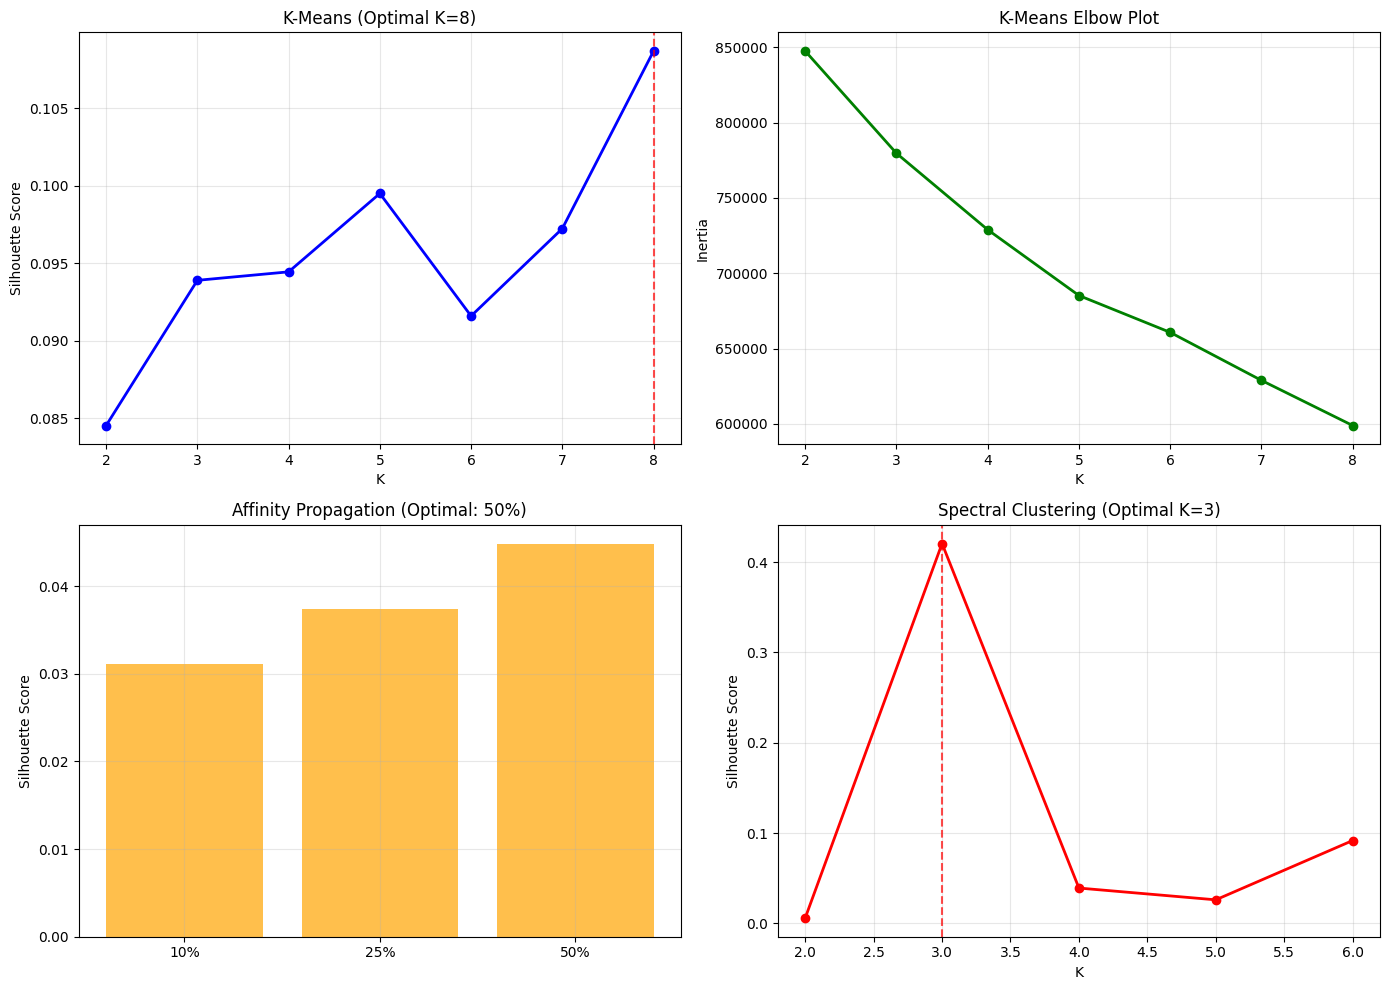

Creating PCA cluster visualizations...


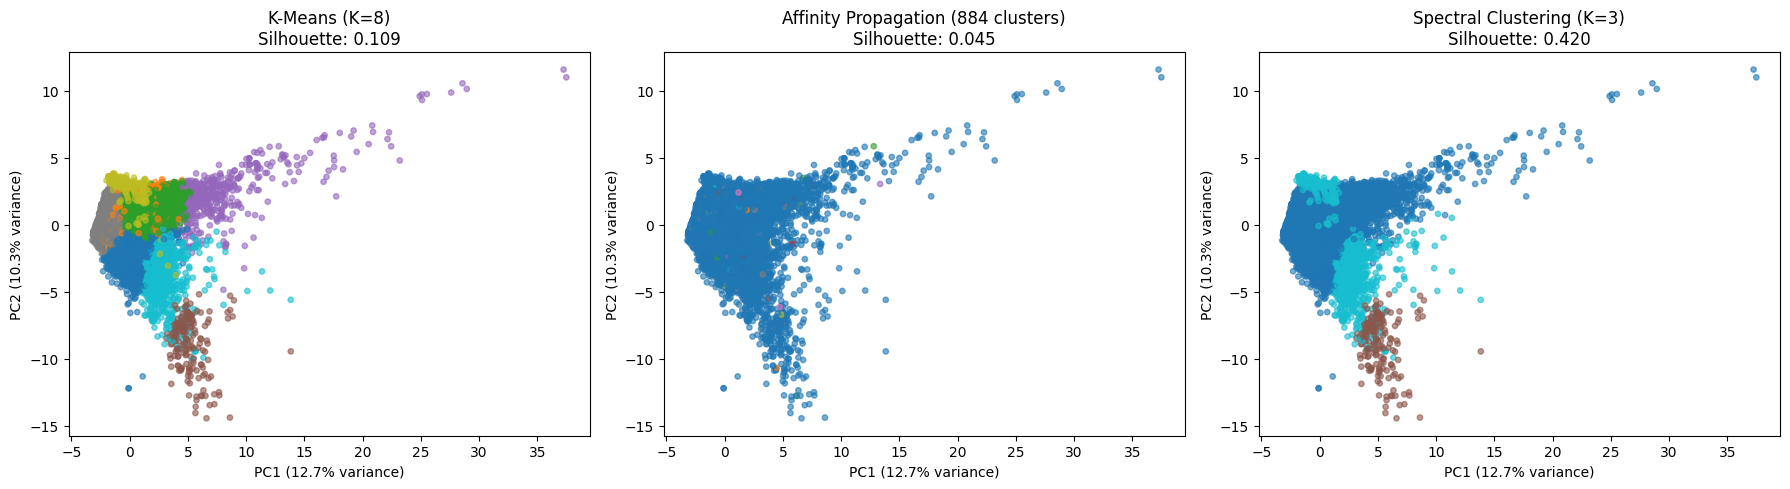


CLUSTER CHARACTERISTICS ANALYSIS
K-MEANS CLUSTER CHARACTERISTICS:
----------------------------------------

Cluster 0 (n=7460, 23.4%):
  Top categorical features:
    animal_type: DOG (71.6%)
    primary_color: BLACK (28.0%)
    secondary_color: None (42.2%)
    sex: Male (53.1%)
  Numerical characteristics:
    age_at_intake_days: 1775.77 (overall: 747.25)
    visit_count: 1.00 (overall: 1.04)

Cluster 1 (n=5030, 15.8%):
  Top categorical features:
    animal_type: CAT (96.1%)
    primary_color: BRN TABBY (43.6%)
    secondary_color: None (68.8%)
    sex: Male (49.9%)
  Numerical characteristics:
    age_at_intake_days: 385.56 (overall: 747.25)
    visit_count: 1.00 (overall: 1.04)

Cluster 2 (n=8245, 25.9%):
  Top categorical features:
    animal_type: CAT (49.6%)
    primary_color: BLACK (34.2%)
    secondary_color: None (45.7%)
    sex: Male (50.3%)
  Numerical characteristics:
    age_at_intake_days: 476.81 (overall: 747.25)
    visit_count: 1.00 (overall: 1.04)

Cluster 3 (n=535

In [112]:
# 1. Silhouette Score Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# K-Means silhouette scores
axes[0, 0].plot(k_range, kmeans_silhouette_scores, 'bo-', linewidth=2, markersize=6)
axes[0, 0].axvline(x=optimal_k_kmeans, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title(f'K-Means (Optimal K={optimal_k_kmeans})')
axes[0, 0].grid(True, alpha=0.3)

# K-Means elbow plot
axes[0, 1].plot(k_range, kmeans_inertias, 'go-', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Inertia')
axes[0, 1].set_title('K-Means Elbow Plot')
axes[0, 1].grid(True, alpha=0.3)

# Affinity Propagation results
if ap_success:
    axes[1, 0].bar(range(len(preference_percentiles)), ap_silhouette_scores, color='orange', alpha=0.7)
    axes[1, 0].set_xticks(range(len(preference_percentiles)))
    axes[1, 0].set_xticklabels([f'{p}%' for p in preference_percentiles])
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_title(f'Affinity Propagation (Optimal: {optimal_pref}%)')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Affinity Propagation\nFailed', ha='center', va='center', 
                   transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('Affinity Propagation (Failed)')

# Spectral Clustering silhouette scores
if spectral_success:
    axes[1, 1].plot(spectral_k_range, spectral_silhouette_scores, 'ro-', linewidth=2, markersize=6)
    axes[1, 1].axvline(x=optimal_k_spectral, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_title(f'Spectral Clustering (Optimal K={optimal_k_spectral})')
else:
    axes[1, 1].text(0.5, 0.5, 'Spectral Clustering\nFailed', ha='center', va='center', 
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Spectral Clustering (Failed)')

axes[1, 1].set_xlabel('K')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. PCA Visualization of Clusters
print("Creating PCA cluster visualizations...")

# Apply PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_processed)

# Create cluster comparison plot
n_plots = sum([1, ap_success, spectral_success])  # Count successful algorithms
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 1:
    axes = [axes]

plot_idx = 0

# K-Means visualization
scatter1 = axes[plot_idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                 c=best_kmeans_labels, cmap='tab10', alpha=0.6, s=15)
axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[plot_idx].set_title(f'K-Means (K={optimal_k_kmeans})\nSilhouette: {max(kmeans_silhouette_scores):.3f}')
plot_idx += 1

# Affinity Propagation visualization
if ap_success:
    # Map AP labels to full dataset
    if len(X_processed) > len(best_ap_labels):
        ap_labels_full = np.full(len(X_processed), -1)
        ap_labels_full[ap_indices] = best_ap_labels
    else:
        ap_labels_full = best_ap_labels
    
    scatter2 = axes[plot_idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                     c=ap_labels_full, cmap='tab10', alpha=0.6, s=15)
    axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[plot_idx].set_title(f'Affinity Propagation ({ap_n_clusters[optimal_pref_idx]} clusters)\nSilhouette: {max(ap_silhouette_scores):.3f}')
    plot_idx += 1

# Spectral Clustering visualization
if spectral_success:
    scatter3 = axes[plot_idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                     c=best_spectral_labels, cmap='tab10', alpha=0.6, s=15)
    axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[plot_idx].set_title(f'Spectral Clustering (K={optimal_k_spectral})\nSilhouette: {max(spectral_silhouette_scores):.3f}')

plt.tight_layout()
plt.show()

# =============================================================================
# CLUSTER ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*60)

# Analyze K-Means clusters (best performer likely)
df_analysis = df_cluster.copy()
df_analysis['KMeans_Cluster'] = best_kmeans_labels

print("K-MEANS CLUSTER CHARACTERISTICS:")
print("-" * 40)

for cluster_id in sorted(df_analysis['KMeans_Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['KMeans_Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    percentage = (cluster_size / len(df_analysis)) * 100
    
    print(f"\nCluster {cluster_id} (n={cluster_size}, {percentage:.1f}%):")
    
    # Top categorical characteristics
    print("  Top categorical features:")
    for cat_col in categorical_cols[:4]:  # Show top 4 categorical features
        if cat_col in cluster_data.columns:
            top_category = cluster_data[cat_col].mode().iloc[0]
            cat_percentage = (cluster_data[cat_col] == top_category).mean() * 100
            print(f"    {cat_col}: {top_category} ({cat_percentage:.1f}%)")
    
    # Numerical characteristics
    print("  Numerical characteristics:")
    key_numerical = ['age_at_intake_days', 'visit_count', 'latitude', 'longitude']
    for num_col in key_numerical:
        if num_col in cluster_data.columns:
            mean_val = cluster_data[num_col].mean()
            overall_mean = df_analysis[num_col].mean()
            print(f"    {num_col}: {mean_val:.2f} (overall: {overall_mean:.2f})")

# =============================================================================
# PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "="*60)
print("ALGORITHM PERFORMANCE SUMMARY")
print("="*60)

results = []
results.append(['K-Means', f'K={optimal_k_kmeans}', f'{max(kmeans_silhouette_scores):.4f}', optimal_k_kmeans])

if ap_success:
    results.append(['Affinity Propagation', f'Pref={optimal_pref}%', f'{max(ap_silhouette_scores):.4f}', ap_n_clusters[optimal_pref_idx]])

if spectral_success:
    results.append(['Spectral Clustering', f'K={optimal_k_spectral}', f'{max(spectral_silhouette_scores):.4f}', optimal_k_spectral])

summary_df = pd.DataFrame(results, columns=['Algorithm', 'Parameters', 'Silhouette_Score', 'N_Clusters'])
print(summary_df.to_string(index=False))

# Find best performing algorithm
best_score = summary_df['Silhouette_Score'].astype(float).max()
best_algorithm = summary_df.loc[summary_df['Silhouette_Score'].astype(float).idxmax(), 'Algorithm']

print(f"\nBest performing algorithm: {best_algorithm}")
print(f"Best silhouette score: {best_score:.4f}")

print(f"\nClustering analysis completed!")
print("Optimizations applied:")
print(f"- Dataset sampled to {len(df_cluster)} rows")
print(f"- Affinity Propagation limited to {AP_SAMPLE_SIZE} samples")
print(f"- Feature engineering with {X_processed.shape[1]} final features")
print("- Efficient algorithm parameters for speed")

In [113]:
_, cluster_labels_k2 = spectral_models[3]

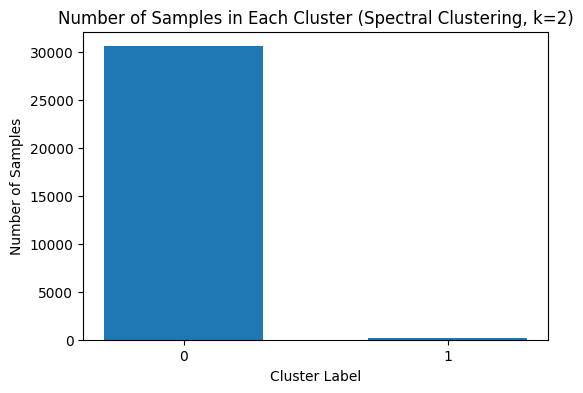

In [114]:
plt.figure(figsize=(6,4))
plt.hist(cluster_labels_k2, bins=np.arange(3)-0.5, rwidth=0.6)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Cluster (Spectral Clustering, k=2)')
plt.xticks([0,1])
plt.show()